In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
M=50
N=40
dx=1
dy=1
dt=0.002
U= 1# Inlet speed u  
mu=1.81*1e-5#8.9*1e-4
rho=1.225#997
# mu=8.9*1e-4
# rho=997
KV=mu/rho
beta=dx/dy

In [53]:
C=U*dt/dx # Courant number
C

0.002

#### Initialization

In [76]:
u=np.zeros((M,N+1))#(5,5)
u[0,:]=U
v=np.zeros((M+1,N))# (6,4)
p=np.zeros((M+1,N+1)) # (6,5)

In [77]:
def update_V_F(u,v,p): # capital V is a vector, indicates u and v
    u_F=np.zeros((M,N+1))
    v_F=np.zeros((M+1,N))
    # loop for u
    for i in range(1,M-1):
        for j in range(1,N):
            # For A
            ududx = u[i,j]/dx * ( (u[i,j]+u[i+1,j])/2 - (u[i,j]+u[i-1,j])/2 )
            vdudy = 1/2 * ( (v[i,j]+v[i+1,j])/2 + (v[i,j-1]+v[i+1,j-1])/2 ) * 1/dy * ((u[i,j]+u[i,j+1])/2 - (u[i,j-1]+u[i,j])/2)
            Ax= -( ududx + vdudy )
            # For B
            d2u_dx2 = (u[i+1,j] - 2*u[i,j] + u[i-1,j]) / (dx**2)
            d2u_dy2 = (u[i,j+1] - 2*u[i,j] + u[i, j-1]) / (dy**2)
            Bx = mu/rho * (d2u_dx2 + d2u_dy2)
            u_F[i,j] = u[i,j] + dt * (Ax + Bx)
    # loop for v
    for i in range(1,M):
        for j in range(1,N-1):
            # For A
            udvdx = 1/2 * ( (u[i,j]+u[i,j+1])/2 + (u[i-1,j]+u[i-1,j+1])/2 ) * 1/dx *( (v[i,j]+v[i+1,j])/2 - (v[i-1,j]+v[i,j])/2 )
            vdvdy = v[i,j]/dy * ( (v[i,j]+v[i,j+1])/2 - (v[i,j]+v[i,j-1])/2 )
            Ay = -( udvdx + vdvdy )
            # For B
            d2v_dx2 = (v[i+1,j] - 2*v[i,j] + v[i-1,j])/(dx**2)
            d2v_dy2 = (v[i,j+1] - 2*v[i,j] + v[i,j-1])/(dy**2)
            By = mu/rho * (d2v_dx2 + d2v_dy2)
            v_F[i,j] = v[i,j] + dt * (Ay + By)
    #BC for Domain
    #bottom wall
    u_F[:,0] = -u_F[:,1]
    v_F[:,0] = 0
    #top
    u_F[:,N] = -u_F[:,N-1]
    v_F[:,N-1] = 0

    #left -- inlet
    u_F[0,:] = U
    v_F[0,:]=-v_F[1,:]

    #outlet-- right
    u_F[M-1,:]=u_F[M-2,:]
    v_F[M,:]=v_F[M-1,:]
    
    # Updata cell
    # For u
    ## middle
    u_F[16:35,11:30]=np.zeros((35-16,30-11))
    ## bottom
    u_F[15:35,10]= - u_F[15:35,9]
    ## top
    u_F[15:35,30]= - u_F[15:35,31]
    ## left
    u_F[14,10:31] = np.zeros(21)
    ## right
    u_F[35,10:31] = np.zeros(21)
    
    # For v
    ## middle
    v_F[16:35,10:30]=np.zeros((35-16,30-10))
    ## bottom
    v_F[15:36,9]= np.zeros(36-15)
    ## top
    v_F[15:36,30]= np.zeros(36-15)
    ## left
    v_F[15,10:30] = - v_F[14,10:30]
    ## right
    v_F[35,10:30] = - v_F[36,10:30]

    return u_F,v_F

In [78]:
import copy
def get_p(u_F,v_F):
    error=5
    p=np.zeros((M+1,N+1))
    p_new=np.zeros((M+1,N+1))
    t=0
    while error>1e-5:
        t+=1
        tem=copy.deepcopy(p)
        for i in range(1,M):
            for j in range(1,N):
                b=1/dt*( (u_F[i,j]-u_F[i-1,j])/dx + (v_F[i,j]-v_F[i,j-1])/dy )
                p_new[i,j]= 1 / (2*(1+beta**2)) *  (p_new[i-1,j] + p[i+1,j] + beta**2 * (p_new[i,j-1]+p[i,j+1]) ) - b * 1 / (2*(1+beta**2))
        error=abs(np.max(p-p_new))
        p=p_new
    #BC for Domain
    #bottom wall
    p[:,0] = p[:,1]
    #top
    p[:,N] = p[:,N-1]
    #left -- inlet
    p[0,:] = p[1,:]
    #outlet-- right
    p[M-1,:]=0
    
    # For cell
    # middle
    p[16:35,10:30] = np.zeros((35-16,30-10))
    # top
    p[16:35,30] = - p[16:35,31]
    # bottom
    p[16:35,10] = - p[16:35,9] 
    # left
    p[15,10:31] = np.zeros((31-10))#- p[14,10:31] 
    # right
    p[35,10:31] = - p[36,10:31]
    return p

In [79]:
def update_V(u_F,v_F,p):
    u=np.zeros((M,N+1))
    v=np.zeros((M+1,N))
    # Update u
    for i in range(1,M-1):
        for j in range(1,N):  
            u[i,j] =u_F[i,j] - dt/dx * (p[i+1,j] - p[i,j])
    # Update v
    for i in range(1,M):
        for j in range(1,N-1):
            v[i,j] = v_F[i,j] - dt/dy * (p[i,j+1] - p[i,j])
            
    #BC for Domain
    #bottom wall
    u[:,0] = -u[:,1]
    v[:,0] = 0
    #top
    u[:,N] = -u[:,N-1]
    v[:,N-1] = 0

    #left -- inlet
    u[0,:] = U
    v[0,:]=-v[1,:]

    #outlet-- right
    u[M-1,:]=u[M-2,:]
    v[M,:]=v[M-1,:]
    
# Updata cell
    # For u
    ## middle
    u[16:35,11:30]=np.zeros((35-16,30-11))
    ## bottom
    u[15:35,10]= - u[15:35,9]
    ## top
    u[15:35,30]= - u[15:35,31]
    ## left
    u[14,10:31] = np.zeros(21)
    ## right
    u[35,10:31] = np.zeros(21)
    
    # For v
    ## middle
    v[16:35,10:30]=np.zeros((35-16,30-10))
    ## bottom
    v[15:36,9]= np.zeros(36-15)
    ## top
    v[15:36,30]= np.zeros(36-15)
    ## left
    v[15,10:30] = - v[14,10:30]
    ## right
    v[35,10:30] = - v[36,10:30]
    return u,v

In [80]:
import copy
def Update_T(u,v,T): 
    T_new=copy.deepcopy(T)
    for i in range(1,M):
        for j in range(1,N):
            if i in list(range(16,35)) and j in list(range(11,30)):
                q=20
            else:
                q=0
            duTdx=1/dx * (u[i,j] * (T[i+1,j] + T[i,j])/2 - u[i-1,j] * (T[i,j] + T[i-1,j])/2)
            dvTdy=1/dy * (v[i,j] * (T[i,j+1] + T[i,j])/2 - v[i,j-1] * (T[i,j] + T[i,j-1])/2)
            T_new[i,j]=T[i,j] + dt * (k/rho/cp * (T[i+1,j] + T[i-1,j] + T[i,j+1] + T[i,j-1] - 4*T[i,j])/dx**2 + q/cp - duTdx - dvTdy)
                
    # update BC
    # left
    T_new[0,:]=T_in
    # right
    T_new[M,:]=T_new[M-1,:]
    # top
    T_new[:,N]=T_new[:,N-1]
    # bottom
    T_new[:,0]=T_new[:,1]

#     #BC for cell
#     #left
#     T_new[15,10:31]=T_new[14,10:31]
#     # right
#     T_new[35,10:31]=T_new[36,10:31]
#     # top
#     T_new[15:36,30]=T_new[15:36,31]
#     # bottom
#     T_new[15:36,10]=T_new[15:36,9]
    return T_new








  0%|          | 0/1500 [00:00<?, ?it/s]






  0%|          | 1/1500 [00:00<05:02,  4.95it/s]






  0%|          | 2/1500 [00:00<04:27,  5.61it/s]






  0%|          | 3/1500 [00:00<04:13,  5.90it/s]






  0%|          | 4/1500 [00:00<04:02,  6.18it/s]






  0%|          | 5/1500 [00:00<03:46,  6.59it/s]






  0%|          | 6/1500 [00:00<03:36,  6.90it/s]






  0%|          | 7/1500 [00:01<03:32,  7.03it/s]






  1%|          | 8/1500 [00:01<03:31,  7.04it/s]






  1%|          | 9/1500 [00:01<03:34,  6.94it/s]






  1%|          | 10/1500 [00:01<03:47,  6.54it/s]






  1%|          | 11/1500 [00:01<03:53,  6.37it/s]






  1%|          | 12/1500 [00:01<03:52,  6.40it/s]






  1%|          | 13/1500 [00:01<03:51,  6.42it/s]






  1%|          | 14/1500 [00:02<03:54,  6.33it/s]






  1%|          | 15/1500 [00:02<04:14,  5.83it/s]






  1%|          | 16/1500 [00:02<04:43,  5.23it/s]






  1%|          | 17/1500 [00:02<05:02,  4.91it/s]






  1

  7%|▋         | 106/1500 [00:16<03:30,  6.63it/s]






  7%|▋         | 107/1500 [00:16<03:26,  6.74it/s]






  7%|▋         | 108/1500 [00:16<03:22,  6.87it/s]






  7%|▋         | 109/1500 [00:16<03:22,  6.88it/s]






  7%|▋         | 110/1500 [00:16<03:21,  6.88it/s]






  7%|▋         | 111/1500 [00:16<03:23,  6.83it/s]






  7%|▋         | 112/1500 [00:17<03:20,  6.93it/s]






  8%|▊         | 113/1500 [00:17<03:18,  6.98it/s]






  8%|▊         | 114/1500 [00:17<03:16,  7.04it/s]






  8%|▊         | 115/1500 [00:17<03:15,  7.09it/s]






  8%|▊         | 116/1500 [00:17<03:17,  7.01it/s]






  8%|▊         | 117/1500 [00:17<03:20,  6.89it/s]






  8%|▊         | 118/1500 [00:17<03:20,  6.91it/s]






  8%|▊         | 119/1500 [00:18<03:18,  6.95it/s]






  8%|▊         | 120/1500 [00:18<03:18,  6.96it/s]






  8%|▊         | 121/1500 [00:18<03:18,  6.96it/s]






  8%|▊         | 122/1500 [00:18<03:17,  6.97it/s]






  8%|▊         | 123/1500 [00:1

 14%|█▍        | 211/1500 [00:33<03:38,  5.91it/s]






 14%|█▍        | 212/1500 [00:33<03:31,  6.09it/s]






 14%|█▍        | 213/1500 [00:33<03:32,  6.06it/s]






 14%|█▍        | 214/1500 [00:33<03:27,  6.21it/s]






 14%|█▍        | 215/1500 [00:33<03:23,  6.31it/s]






 14%|█▍        | 216/1500 [00:33<03:19,  6.44it/s]






 14%|█▍        | 217/1500 [00:34<03:18,  6.48it/s]






 15%|█▍        | 218/1500 [00:34<03:14,  6.58it/s]






 15%|█▍        | 219/1500 [00:34<03:16,  6.53it/s]






 15%|█▍        | 220/1500 [00:34<03:13,  6.61it/s]






 15%|█▍        | 221/1500 [00:34<03:13,  6.62it/s]






 15%|█▍        | 222/1500 [00:34<03:13,  6.62it/s]






 15%|█▍        | 223/1500 [00:35<03:11,  6.66it/s]






 15%|█▍        | 224/1500 [00:35<03:10,  6.69it/s]






 15%|█▌        | 225/1500 [00:35<03:12,  6.62it/s]






 15%|█▌        | 226/1500 [00:35<03:15,  6.53it/s]






 15%|█▌        | 227/1500 [00:35<03:15,  6.52it/s]






 15%|█▌        | 228/1500 [00:3

 21%|██        | 316/1500 [00:49<03:17,  6.01it/s]






 21%|██        | 317/1500 [00:50<03:17,  6.00it/s]






 21%|██        | 318/1500 [00:50<04:39,  4.23it/s]






 21%|██▏       | 319/1500 [00:50<04:11,  4.69it/s]






 21%|██▏       | 320/1500 [00:50<03:53,  5.06it/s]






 21%|██▏       | 321/1500 [00:50<03:40,  5.34it/s]






 21%|██▏       | 322/1500 [00:51<03:31,  5.56it/s]






 22%|██▏       | 323/1500 [00:51<03:26,  5.71it/s]






 22%|██▏       | 324/1500 [00:51<03:23,  5.79it/s]






 22%|██▏       | 325/1500 [00:51<03:18,  5.90it/s]






 22%|██▏       | 326/1500 [00:51<03:15,  6.01it/s]






 22%|██▏       | 327/1500 [00:51<03:13,  6.05it/s]






 22%|██▏       | 328/1500 [00:52<03:11,  6.13it/s]






 22%|██▏       | 329/1500 [00:52<03:09,  6.18it/s]






 22%|██▏       | 330/1500 [00:52<03:09,  6.17it/s]






 22%|██▏       | 331/1500 [00:52<03:07,  6.25it/s]






 22%|██▏       | 332/1500 [00:52<03:09,  6.17it/s]






 22%|██▏       | 333/1500 [00:5

 28%|██▊       | 421/1500 [01:07<03:12,  5.61it/s]






 28%|██▊       | 422/1500 [01:07<03:10,  5.65it/s]






 28%|██▊       | 423/1500 [01:08<03:09,  5.67it/s]






 28%|██▊       | 424/1500 [01:08<03:08,  5.70it/s]






 28%|██▊       | 425/1500 [01:08<03:08,  5.72it/s]






 28%|██▊       | 426/1500 [01:08<03:07,  5.71it/s]






 28%|██▊       | 427/1500 [01:08<03:08,  5.71it/s]






 29%|██▊       | 428/1500 [01:09<03:05,  5.78it/s]






 29%|██▊       | 429/1500 [01:09<03:05,  5.76it/s]






 29%|██▊       | 430/1500 [01:09<04:21,  4.10it/s]






 29%|██▊       | 431/1500 [01:09<03:54,  4.57it/s]






 29%|██▉       | 432/1500 [01:09<03:35,  4.96it/s]






 29%|██▉       | 433/1500 [01:10<03:23,  5.25it/s]






 29%|██▉       | 434/1500 [01:10<03:12,  5.53it/s]






 29%|██▉       | 435/1500 [01:10<03:06,  5.71it/s]






 29%|██▉       | 436/1500 [01:10<03:02,  5.83it/s]






 29%|██▉       | 437/1500 [01:10<03:02,  5.83it/s]






 29%|██▉       | 438/1500 [01:1

 35%|███▌      | 526/1500 [01:26<02:53,  5.62it/s]






 35%|███▌      | 527/1500 [01:26<02:51,  5.66it/s]






 35%|███▌      | 528/1500 [01:27<02:51,  5.67it/s]






 35%|███▌      | 529/1500 [01:27<02:52,  5.63it/s]






 35%|███▌      | 530/1500 [01:27<02:53,  5.59it/s]






 35%|███▌      | 531/1500 [01:27<02:54,  5.55it/s]






 35%|███▌      | 532/1500 [01:27<02:58,  5.43it/s]






 36%|███▌      | 533/1500 [01:28<04:08,  3.90it/s]






 36%|███▌      | 534/1500 [01:28<03:48,  4.23it/s]






 36%|███▌      | 535/1500 [01:28<03:37,  4.43it/s]






 36%|███▌      | 536/1500 [01:28<03:30,  4.57it/s]






 36%|███▌      | 537/1500 [01:28<03:17,  4.88it/s]






 36%|███▌      | 538/1500 [01:29<03:05,  5.20it/s]






 36%|███▌      | 539/1500 [01:29<03:46,  4.24it/s]






 36%|███▌      | 540/1500 [01:29<03:38,  4.40it/s]






 36%|███▌      | 541/1500 [01:29<03:28,  4.59it/s]






 36%|███▌      | 542/1500 [01:30<03:15,  4.90it/s]






 36%|███▌      | 543/1500 [01:3

 42%|████▏     | 631/1500 [01:46<02:47,  5.18it/s]






 42%|████▏     | 632/1500 [01:46<02:43,  5.30it/s]






 42%|████▏     | 633/1500 [01:46<02:39,  5.44it/s]






 42%|████▏     | 634/1500 [01:46<02:36,  5.53it/s]






 42%|████▏     | 635/1500 [01:47<02:35,  5.58it/s]






 42%|████▏     | 636/1500 [01:47<02:33,  5.63it/s]






 42%|████▏     | 637/1500 [01:47<02:35,  5.53it/s]






 43%|████▎     | 638/1500 [01:47<02:37,  5.46it/s]






 43%|████▎     | 639/1500 [01:47<02:41,  5.34it/s]






 43%|████▎     | 640/1500 [01:48<02:38,  5.44it/s]






 43%|████▎     | 641/1500 [01:48<02:36,  5.49it/s]






 43%|████▎     | 642/1500 [01:48<02:37,  5.46it/s]






 43%|████▎     | 643/1500 [01:48<02:35,  5.50it/s]






 43%|████▎     | 644/1500 [01:48<02:38,  5.40it/s]






 43%|████▎     | 645/1500 [01:49<02:37,  5.42it/s]






 43%|████▎     | 646/1500 [01:49<02:37,  5.41it/s]






 43%|████▎     | 647/1500 [01:49<02:37,  5.43it/s]






 43%|████▎     | 648/1500 [01:4

 49%|████▉     | 736/1500 [02:06<02:21,  5.41it/s]






 49%|████▉     | 737/1500 [02:07<02:20,  5.43it/s]






 49%|████▉     | 738/1500 [02:07<02:17,  5.53it/s]






 49%|████▉     | 739/1500 [02:07<02:23,  5.30it/s]






 49%|████▉     | 740/1500 [02:07<02:23,  5.29it/s]






 49%|████▉     | 741/1500 [02:07<02:23,  5.29it/s]






 49%|████▉     | 742/1500 [02:08<02:24,  5.26it/s]






 50%|████▉     | 743/1500 [02:08<02:23,  5.26it/s]






 50%|████▉     | 744/1500 [02:08<02:23,  5.28it/s]






 50%|████▉     | 745/1500 [02:08<02:25,  5.19it/s]






 50%|████▉     | 746/1500 [02:08<02:25,  5.17it/s]






 50%|████▉     | 747/1500 [02:09<02:25,  5.19it/s]






 50%|████▉     | 748/1500 [02:09<02:24,  5.20it/s]






 50%|████▉     | 749/1500 [02:09<02:26,  5.12it/s]






 50%|█████     | 750/1500 [02:09<02:24,  5.20it/s]






 50%|█████     | 751/1500 [02:09<02:23,  5.21it/s]






 50%|█████     | 752/1500 [02:10<02:21,  5.30it/s]






 50%|█████     | 753/1500 [02:1

 56%|█████▌    | 841/1500 [02:27<02:05,  5.24it/s]






 56%|█████▌    | 842/1500 [02:27<02:07,  5.18it/s]






 56%|█████▌    | 843/1500 [02:27<02:06,  5.19it/s]






 56%|█████▋    | 844/1500 [02:27<02:05,  5.23it/s]






 56%|█████▋    | 845/1500 [02:28<02:06,  5.17it/s]






 56%|█████▋    | 846/1500 [02:28<02:06,  5.18it/s]






 56%|█████▋    | 847/1500 [02:28<02:06,  5.17it/s]






 57%|█████▋    | 848/1500 [02:28<02:06,  5.14it/s]






 57%|█████▋    | 849/1500 [02:28<02:05,  5.19it/s]






 57%|█████▋    | 850/1500 [02:29<02:04,  5.21it/s]






 57%|█████▋    | 851/1500 [02:29<02:05,  5.19it/s]






 57%|█████▋    | 852/1500 [02:29<02:03,  5.23it/s]






 57%|█████▋    | 853/1500 [02:29<02:04,  5.19it/s]






 57%|█████▋    | 854/1500 [02:29<02:04,  5.20it/s]






 57%|█████▋    | 855/1500 [02:30<02:04,  5.17it/s]






 57%|█████▋    | 856/1500 [02:30<02:06,  5.10it/s]






 57%|█████▋    | 857/1500 [02:30<02:05,  5.11it/s]






 57%|█████▋    | 858/1500 [02:3

 63%|██████▎   | 946/1500 [02:48<01:52,  4.94it/s]






 63%|██████▎   | 947/1500 [02:48<01:52,  4.90it/s]






 63%|██████▎   | 948/1500 [02:48<01:51,  4.95it/s]






 63%|██████▎   | 949/1500 [02:48<01:51,  4.94it/s]






 63%|██████▎   | 950/1500 [02:49<01:50,  4.98it/s]






 63%|██████▎   | 951/1500 [02:49<01:49,  5.04it/s]






 63%|██████▎   | 952/1500 [02:49<01:48,  5.07it/s]






 64%|██████▎   | 953/1500 [02:49<01:47,  5.09it/s]






 64%|██████▎   | 954/1500 [02:49<01:48,  5.03it/s]






 64%|██████▎   | 955/1500 [02:50<01:46,  5.10it/s]






 64%|██████▎   | 956/1500 [02:50<01:46,  5.11it/s]






 64%|██████▍   | 957/1500 [02:50<01:46,  5.10it/s]






 64%|██████▍   | 958/1500 [02:50<01:45,  5.12it/s]






 64%|██████▍   | 959/1500 [02:50<01:45,  5.13it/s]






 64%|██████▍   | 960/1500 [02:50<01:45,  5.12it/s]






 64%|██████▍   | 961/1500 [02:51<01:45,  5.11it/s]






 64%|██████▍   | 962/1500 [02:51<01:44,  5.13it/s]






 64%|██████▍   | 963/1500 [02:5

 70%|███████   | 1050/1500 [03:09<01:28,  5.08it/s]






 70%|███████   | 1051/1500 [03:09<01:30,  4.98it/s]






 70%|███████   | 1052/1500 [03:10<01:29,  5.00it/s]






 70%|███████   | 1053/1500 [03:10<01:29,  4.97it/s]






 70%|███████   | 1054/1500 [03:10<01:30,  4.95it/s]






 70%|███████   | 1055/1500 [03:10<01:29,  4.96it/s]






 70%|███████   | 1056/1500 [03:10<01:29,  4.96it/s]






 70%|███████   | 1057/1500 [03:11<01:28,  4.99it/s]






 71%|███████   | 1058/1500 [03:11<01:31,  4.85it/s]






 71%|███████   | 1059/1500 [03:11<01:32,  4.79it/s]






 71%|███████   | 1060/1500 [03:11<01:34,  4.68it/s]






 71%|███████   | 1061/1500 [03:11<01:37,  4.51it/s]






 71%|███████   | 1062/1500 [03:12<01:34,  4.62it/s]






 71%|███████   | 1063/1500 [03:12<01:32,  4.70it/s]






 71%|███████   | 1064/1500 [03:12<01:30,  4.80it/s]






 71%|███████   | 1065/1500 [03:12<01:32,  4.69it/s]






 71%|███████   | 1066/1500 [03:12<01:31,  4.74it/s]






 71%|███████  

 77%|███████▋  | 1153/1500 [03:31<01:10,  4.92it/s]






 77%|███████▋  | 1154/1500 [03:31<01:10,  4.88it/s]






 77%|███████▋  | 1155/1500 [03:31<01:08,  5.00it/s]






 77%|███████▋  | 1156/1500 [03:32<01:07,  5.06it/s]






 77%|███████▋  | 1157/1500 [03:32<01:08,  4.98it/s]






 77%|███████▋  | 1158/1500 [03:32<01:10,  4.88it/s]






 77%|███████▋  | 1159/1500 [03:32<01:10,  4.82it/s]






 77%|███████▋  | 1160/1500 [03:33<01:37,  3.48it/s]






 77%|███████▋  | 1161/1500 [03:33<01:28,  3.81it/s]






 77%|███████▋  | 1162/1500 [03:33<01:22,  4.09it/s]






 78%|███████▊  | 1163/1500 [03:33<01:18,  4.30it/s]






 78%|███████▊  | 1164/1500 [03:34<01:15,  4.47it/s]






 78%|███████▊  | 1165/1500 [03:34<01:13,  4.54it/s]






 78%|███████▊  | 1166/1500 [03:34<01:11,  4.65it/s]






 78%|███████▊  | 1167/1500 [03:34<01:10,  4.70it/s]






 78%|███████▊  | 1168/1500 [03:34<01:09,  4.75it/s]






 78%|███████▊  | 1169/1500 [03:35<01:09,  4.77it/s]






 78%|███████▊ 

 84%|████████▎ | 1256/1500 [03:53<00:53,  4.59it/s]






 84%|████████▍ | 1257/1500 [03:54<00:53,  4.53it/s]






 84%|████████▍ | 1258/1500 [03:54<00:51,  4.66it/s]






 84%|████████▍ | 1259/1500 [03:54<00:50,  4.74it/s]






 84%|████████▍ | 1260/1500 [03:54<00:50,  4.76it/s]






 84%|████████▍ | 1261/1500 [03:54<00:49,  4.82it/s]






 84%|████████▍ | 1262/1500 [03:55<00:49,  4.84it/s]






 84%|████████▍ | 1263/1500 [03:55<00:48,  4.87it/s]






 84%|████████▍ | 1264/1500 [03:55<00:48,  4.85it/s]






 84%|████████▍ | 1265/1500 [03:55<00:48,  4.82it/s]






 84%|████████▍ | 1266/1500 [03:55<00:48,  4.86it/s]






 84%|████████▍ | 1267/1500 [03:56<00:48,  4.77it/s]






 85%|████████▍ | 1268/1500 [03:56<00:48,  4.79it/s]






 85%|████████▍ | 1269/1500 [03:56<00:47,  4.84it/s]






 85%|████████▍ | 1270/1500 [03:56<00:47,  4.87it/s]






 85%|████████▍ | 1271/1500 [03:56<00:47,  4.82it/s]






 85%|████████▍ | 1272/1500 [03:57<00:47,  4.82it/s]






 85%|████████▍

 91%|█████████ | 1359/1500 [04:21<00:29,  4.78it/s]






 91%|█████████ | 1360/1500 [04:22<00:29,  4.76it/s]






 91%|█████████ | 1361/1500 [04:22<00:29,  4.69it/s]






 91%|█████████ | 1362/1500 [04:22<00:29,  4.73it/s]






 91%|█████████ | 1363/1500 [04:22<00:28,  4.76it/s]






 91%|█████████ | 1364/1500 [04:22<00:28,  4.75it/s]






 91%|█████████ | 1365/1500 [04:23<00:28,  4.73it/s]






 91%|█████████ | 1366/1500 [04:23<00:28,  4.68it/s]






 91%|█████████ | 1367/1500 [04:23<00:28,  4.70it/s]






 91%|█████████ | 1368/1500 [04:23<00:28,  4.66it/s]






 91%|█████████▏| 1369/1500 [04:24<00:27,  4.82it/s]






 91%|█████████▏| 1370/1500 [04:24<00:26,  4.91it/s]






 91%|█████████▏| 1371/1500 [04:24<00:27,  4.68it/s]






 91%|█████████▏| 1372/1500 [04:24<00:28,  4.56it/s]






 92%|█████████▏| 1373/1500 [04:24<00:30,  4.21it/s]






 92%|█████████▏| 1374/1500 [04:25<00:33,  3.77it/s]






 92%|█████████▏| 1375/1500 [04:25<00:32,  3.83it/s]






 92%|█████████

 97%|█████████▋| 1462/1500 [04:43<00:07,  4.98it/s]






 98%|█████████▊| 1463/1500 [04:43<00:07,  4.95it/s]






 98%|█████████▊| 1464/1500 [04:44<00:07,  4.97it/s]






 98%|█████████▊| 1465/1500 [04:44<00:07,  5.00it/s]






 98%|█████████▊| 1466/1500 [04:44<00:07,  4.85it/s]






 98%|█████████▊| 1467/1500 [04:44<00:06,  4.73it/s]






 98%|█████████▊| 1468/1500 [04:44<00:06,  4.75it/s]






 98%|█████████▊| 1469/1500 [04:45<00:06,  4.83it/s]






 98%|█████████▊| 1470/1500 [04:45<00:06,  4.88it/s]






 98%|█████████▊| 1471/1500 [04:45<00:05,  4.97it/s]






 98%|█████████▊| 1472/1500 [04:45<00:05,  5.01it/s]






 98%|█████████▊| 1473/1500 [04:45<00:05,  5.03it/s]






 98%|█████████▊| 1474/1500 [04:46<00:05,  5.06it/s]






 98%|█████████▊| 1475/1500 [04:46<00:04,  5.04it/s]






 98%|█████████▊| 1476/1500 [04:46<00:04,  5.03it/s]






 98%|█████████▊| 1477/1500 [04:46<00:04,  5.00it/s]






 99%|█████████▊| 1478/1500 [04:46<00:04,  4.99it/s]






 99%|█████████

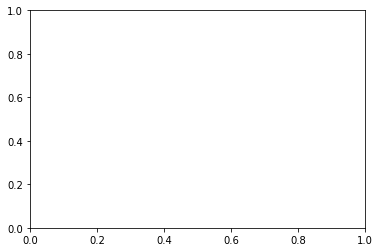

In [81]:
from tqdm import tqdm
for t in tqdm(range(1500)):

    u_F,v_F=update_V_F(u,v,p)
    p = get_p(u_F,v_F)
    u,v = update_V(u_F,v_F,p)
    image=plt.contourf(u.T,levels = 25)
    plt.savefig('u/%04d.png' % t)
    plt.cla()
#     image=plt.contourf(v.T,levels = 25)
#     plt.savefig('v/%04d.png' % t)
#     plt.cla()
#     del(image)
    
#     image = plt.imshow(fmap)
# plt.savefig('m'+str(m)+'_i'+str(i)+'.png')
# del(image)

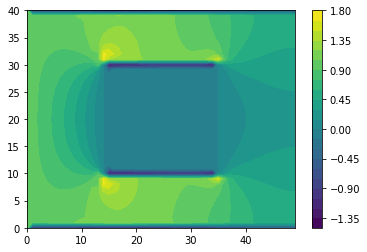

In [10]:
plt.contourf(u.T,levels = 25)
plt.savefig('u/i.png')
plt.colorbar()

(49, 39)
(49, 39)


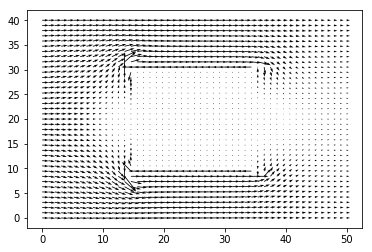

In [11]:
vel_U=u[1:M,1:N]#.transpose()
print(vel_U.shape)
vel_V=v[1:M,1:N]#.transpose()
print(vel_V.shape)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig, ax = plt.subplots()
X, Y = np.mgrid[0:50:49j, 0:40:39j]
ax.quiver(X, Y ,vel_U,vel_V)

plt.show()

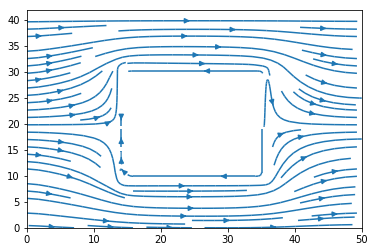

In [12]:
Y, X= np.mgrid[0:40:39j, 0:50:49j]
plt.streamplot(X,Y,vel_U.transpose(), vel_V.transpose())
plt.show()

In [91]:
def Update_T(u,v,T): 
    for i in range(1,M):
        for j in range(1,N):
            if i in list(range(15,36)) and j in list(range(10,31)):
                k=1
                q=2
            else:
                q=0
                k=0.8
#             duTdx = 1/dx * ( u[i,j] * (T[i+1,j]+T[i,j])/2 - u[i-1,j] * (T[i,j] + T[i-1,j])/2 )
#             dvTdy = 1/dy * ( v[i,j] * (T[i,j+1]+T[i,j])/2 - v[i,j-1] * (T[i,j] + T[i,j-1])/2 )
#             T[i,j] = T[i,j] + dt *(k/(cp * rho) * 1/dx**2 * (T[i+1,j]+T[i-1,j]+T[i,j+1]+T[i,j-1]-4*T[i,j]) + q/cp - duTdx - dvTdy)    

            duTdx = (u[i,j] + u[i-1,j])/2 * ((T[i+1,j] + T[i,j])/2 - (T[i,j] + T[i-1,j])/2) /dx
            dvTdy = (v[i,j] + v[i,j-1])/2 * ((T[i,j] + T[i,j+1])/2 - (T[i,j] + T[i,j-1])/2) /dy 
            T[i,j] = T[i,j] + dt *(k/(cp * rho) * 1/dx**2 * (T[i+1,j]+T[i-1,j]+T[i,j+1]+T[i,j-1]-4*T[i,j]) + q/cp - duTdx - dvTdy)
    # update BC
    # left
    T[0,:]=298
    # right
    T[M,:]=T[M-1,:]
    # top
    T[:,N]=T[:,N-1]
    # bottom
    T[:,0]=T[:,1]

    #BC for cell
    #left
#     T[15,10:31]=T[14,10:31]
#     # right
#     T[35,10:31]=T[36,10:31]
#     # top
#     T[15:36,30]=T[15:36,31]
#     # bottom
#     T[15:36,10]=T[15:36,9]
    return T

In [92]:
T=np.ones((M+1, N+1))*0
## middle
T[15:36,10:31]=np.ones((36-15,31-10))*360
T[0,:]=np.ones(N+1)*280
k=1.4
cp=1
q=0

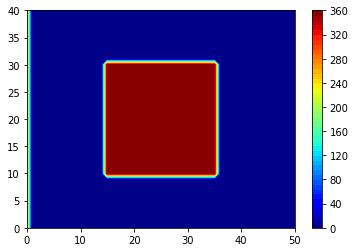

In [93]:
plt.contourf(T.T,levels = 50,cmap='jet')
plt.colorbar()

In [94]:
u_=copy.deepcopy(u)
v_=copy.deepcopy(v)
u_[15:36,10:31]=np.zeros((36-15,31-10))
v_[15:36,10:31]=np.zeros((36-15,31-10))









  0%|          | 0/10000 [00:00<?, ?it/s]






  0%|          | 1/10000 [00:00<29:06,  5.73it/s]






  0%|          | 2/10000 [00:00<30:54,  5.39it/s]






  0%|          | 3/10000 [00:00<30:57,  5.38it/s]






  0%|          | 4/10000 [00:00<27:43,  6.01it/s]






  0%|          | 5/10000 [00:00<26:28,  6.29it/s]






  0%|          | 6/10000 [00:00<25:09,  6.62it/s]






  0%|          | 7/10000 [00:01<26:23,  6.31it/s]






  0%|          | 8/10000 [00:01<24:43,  6.74it/s]






  0%|          | 9/10000 [00:01<25:40,  6.49it/s]






  0%|          | 10/10000 [00:01<29:40,  5.61it/s]






  0%|          | 11/10000 [00:01<27:33,  6.04it/s]






  0%|          | 12/10000 [00:01<27:40,  6.02it/s]






  0%|          | 13/10000 [00:02<25:11,  6.61it/s]






  0%|          | 14/10000 [00:02<23:57,  6.95it/s]






  0%|          | 15/10000 [00:02<25:45,  6.46it/s]






  0%|          | 16/10000 [00:02<23:37,  7.05it/s]






  0%|          | 17/10000 [00:02<21:41,  7

  1%|          | 105/10000 [00:18<40:18,  4.09it/s]






  1%|          | 106/10000 [00:18<38:01,  4.34it/s]






  1%|          | 107/10000 [00:18<33:34,  4.91it/s]






  1%|          | 108/10000 [00:18<31:17,  5.27it/s]






  1%|          | 109/10000 [00:18<27:28,  6.00it/s]






  1%|          | 110/10000 [00:18<24:54,  6.62it/s]






  1%|          | 111/10000 [00:18<23:13,  7.10it/s]






  1%|          | 112/10000 [00:19<21:44,  7.58it/s]






  1%|          | 113/10000 [00:19<20:30,  8.04it/s]






  1%|          | 114/10000 [00:19<19:40,  8.38it/s]






  1%|          | 115/10000 [00:19<23:34,  6.99it/s]






  1%|          | 116/10000 [00:19<28:59,  5.68it/s]






  1%|          | 117/10000 [00:19<32:11,  5.12it/s]






  1%|          | 118/10000 [00:20<33:39,  4.89it/s]






  1%|          | 119/10000 [00:20<32:23,  5.08it/s]






  1%|          | 120/10000 [00:20<31:00,  5.31it/s]






  1%|          | 121/10000 [00:20<28:53,  5.70it/s]






  1%|         

  2%|▏         | 208/10000 [00:34<21:24,  7.62it/s]






  2%|▏         | 209/10000 [00:34<21:15,  7.68it/s]






  2%|▏         | 210/10000 [00:34<20:59,  7.77it/s]






  2%|▏         | 211/10000 [00:34<20:20,  8.02it/s]






  2%|▏         | 212/10000 [00:35<23:25,  6.97it/s]






  2%|▏         | 213/10000 [00:35<24:30,  6.65it/s]






  2%|▏         | 214/10000 [00:35<23:51,  6.84it/s]






  2%|▏         | 215/10000 [00:35<23:22,  6.98it/s]






  2%|▏         | 216/10000 [00:35<23:02,  7.08it/s]






  2%|▏         | 217/10000 [00:35<24:05,  6.77it/s]






  2%|▏         | 218/10000 [00:35<23:35,  6.91it/s]






  2%|▏         | 219/10000 [00:36<24:55,  6.54it/s]






  2%|▏         | 220/10000 [00:36<25:26,  6.41it/s]






  2%|▏         | 221/10000 [00:36<23:35,  6.91it/s]






  2%|▏         | 222/10000 [00:36<22:19,  7.30it/s]






  2%|▏         | 223/10000 [00:36<21:14,  7.67it/s]






  2%|▏         | 224/10000 [00:36<20:28,  7.95it/s]






  2%|▏        

  3%|▎         | 311/10000 [00:47<20:51,  7.74it/s]






  3%|▎         | 312/10000 [00:47<20:45,  7.78it/s]






  3%|▎         | 313/10000 [00:47<20:45,  7.78it/s]






  3%|▎         | 314/10000 [00:48<20:09,  8.01it/s]






  3%|▎         | 315/10000 [00:48<19:24,  8.32it/s]






  3%|▎         | 316/10000 [00:48<19:23,  8.32it/s]






  3%|▎         | 317/10000 [00:48<19:31,  8.27it/s]






  3%|▎         | 318/10000 [00:48<19:37,  8.22it/s]






  3%|▎         | 319/10000 [00:48<20:03,  8.04it/s]






  3%|▎         | 320/10000 [00:48<19:39,  8.21it/s]






  3%|▎         | 321/10000 [00:48<19:47,  8.15it/s]






  3%|▎         | 322/10000 [00:49<19:47,  8.15it/s]






  3%|▎         | 323/10000 [00:49<19:40,  8.20it/s]






  3%|▎         | 324/10000 [00:49<19:30,  8.26it/s]






  3%|▎         | 325/10000 [00:49<20:02,  8.04it/s]






  3%|▎         | 326/10000 [00:49<19:56,  8.09it/s]






  3%|▎         | 327/10000 [00:49<19:47,  8.14it/s]






  3%|▎        

  4%|▍         | 414/10000 [01:01<22:41,  7.04it/s]






  4%|▍         | 415/10000 [01:01<22:40,  7.05it/s]






  4%|▍         | 416/10000 [01:01<22:13,  7.19it/s]






  4%|▍         | 417/10000 [01:02<21:52,  7.30it/s]






  4%|▍         | 418/10000 [01:02<21:50,  7.31it/s]






  4%|▍         | 419/10000 [01:02<21:22,  7.47it/s]






  4%|▍         | 420/10000 [01:02<20:58,  7.61it/s]






  4%|▍         | 421/10000 [01:02<20:47,  7.68it/s]






  4%|▍         | 422/10000 [01:02<20:29,  7.79it/s]






  4%|▍         | 423/10000 [01:02<20:39,  7.73it/s]






  4%|▍         | 424/10000 [01:02<20:41,  7.71it/s]






  4%|▍         | 425/10000 [01:03<20:40,  7.72it/s]






  4%|▍         | 426/10000 [01:03<20:57,  7.62it/s]






  4%|▍         | 427/10000 [01:03<20:56,  7.62it/s]






  4%|▍         | 428/10000 [01:03<28:43,  5.55it/s]






  4%|▍         | 429/10000 [01:03<26:54,  5.93it/s]






  4%|▍         | 430/10000 [01:03<25:23,  6.28it/s]






  4%|▍        

  5%|▌         | 517/10000 [01:16<23:03,  6.86it/s]






  5%|▌         | 518/10000 [01:16<23:04,  6.85it/s]






  5%|▌         | 519/10000 [01:16<22:32,  7.01it/s]






  5%|▌         | 520/10000 [01:16<22:07,  7.14it/s]






  5%|▌         | 521/10000 [01:16<30:25,  5.19it/s]






  5%|▌         | 522/10000 [01:17<28:39,  5.51it/s]






  5%|▌         | 523/10000 [01:17<26:25,  5.98it/s]






  5%|▌         | 524/10000 [01:17<24:54,  6.34it/s]






  5%|▌         | 525/10000 [01:17<23:45,  6.65it/s]






  5%|▌         | 526/10000 [01:17<22:49,  6.92it/s]






  5%|▌         | 527/10000 [01:17<22:36,  6.98it/s]






  5%|▌         | 528/10000 [01:17<21:49,  7.23it/s]






  5%|▌         | 529/10000 [01:18<21:27,  7.36it/s]






  5%|▌         | 530/10000 [01:18<21:33,  7.32it/s]






  5%|▌         | 531/10000 [01:18<20:59,  7.52it/s]






  5%|▌         | 532/10000 [01:18<22:04,  7.15it/s]






  5%|▌         | 533/10000 [01:18<21:41,  7.27it/s]






  5%|▌        

  6%|▌         | 620/10000 [01:32<25:26,  6.15it/s]






  6%|▌         | 621/10000 [01:32<24:44,  6.32it/s]






  6%|▌         | 622/10000 [01:32<24:02,  6.50it/s]






  6%|▌         | 623/10000 [01:32<23:31,  6.64it/s]






  6%|▌         | 624/10000 [01:32<22:50,  6.84it/s]






  6%|▋         | 625/10000 [01:32<22:03,  7.08it/s]






  6%|▋         | 626/10000 [01:33<21:59,  7.10it/s]






  6%|▋         | 627/10000 [01:33<24:27,  6.39it/s]






  6%|▋         | 628/10000 [01:33<25:31,  6.12it/s]






  6%|▋         | 629/10000 [01:33<24:30,  6.37it/s]






  6%|▋         | 630/10000 [01:33<23:30,  6.64it/s]






  6%|▋         | 631/10000 [01:33<22:37,  6.90it/s]






  6%|▋         | 632/10000 [01:34<21:52,  7.14it/s]






  6%|▋         | 633/10000 [01:34<21:29,  7.27it/s]






  6%|▋         | 634/10000 [01:34<21:12,  7.36it/s]






  6%|▋         | 635/10000 [01:34<21:05,  7.40it/s]






  6%|▋         | 636/10000 [01:34<20:54,  7.46it/s]






  6%|▋        

  7%|▋         | 723/10000 [01:46<22:37,  6.83it/s]






  7%|▋         | 724/10000 [01:47<22:34,  6.85it/s]






  7%|▋         | 725/10000 [01:47<22:30,  6.87it/s]






  7%|▋         | 726/10000 [01:47<22:22,  6.91it/s]






  7%|▋         | 727/10000 [01:47<22:03,  7.00it/s]






  7%|▋         | 728/10000 [01:47<21:39,  7.13it/s]






  7%|▋         | 729/10000 [01:47<22:10,  6.97it/s]






  7%|▋         | 730/10000 [01:47<21:55,  7.05it/s]






  7%|▋         | 731/10000 [01:47<21:47,  7.09it/s]






  7%|▋         | 732/10000 [01:48<21:30,  7.18it/s]






  7%|▋         | 733/10000 [01:48<21:27,  7.19it/s]






  7%|▋         | 734/10000 [01:48<21:00,  7.35it/s]






  7%|▋         | 735/10000 [01:48<20:52,  7.40it/s]






  7%|▋         | 736/10000 [01:48<20:40,  7.47it/s]






  7%|▋         | 737/10000 [01:48<21:33,  7.16it/s]






  7%|▋         | 738/10000 [01:48<21:46,  7.09it/s]






  7%|▋         | 739/10000 [01:49<22:01,  7.01it/s]






  7%|▋        

  8%|▊         | 826/10000 [02:02<25:10,  6.07it/s]






  8%|▊         | 827/10000 [02:02<24:26,  6.25it/s]






  8%|▊         | 828/10000 [02:02<23:38,  6.46it/s]






  8%|▊         | 829/10000 [02:02<22:58,  6.65it/s]






  8%|▊         | 830/10000 [02:03<24:54,  6.13it/s]






  8%|▊         | 831/10000 [02:03<24:28,  6.24it/s]






  8%|▊         | 832/10000 [02:03<23:28,  6.51it/s]






  8%|▊         | 833/10000 [02:03<22:29,  6.79it/s]






  8%|▊         | 834/10000 [02:03<21:44,  7.02it/s]






  8%|▊         | 835/10000 [02:03<21:28,  7.11it/s]






  8%|▊         | 836/10000 [02:04<21:10,  7.22it/s]






  8%|▊         | 837/10000 [02:04<21:07,  7.23it/s]






  8%|▊         | 838/10000 [02:04<21:08,  7.22it/s]






  8%|▊         | 839/10000 [02:04<21:04,  7.25it/s]






  8%|▊         | 840/10000 [02:04<20:58,  7.28it/s]






  8%|▊         | 841/10000 [02:04<22:10,  6.88it/s]






  8%|▊         | 842/10000 [02:04<21:48,  7.00it/s]






  8%|▊        

  9%|▉         | 929/10000 [02:18<22:33,  6.70it/s]






  9%|▉         | 930/10000 [02:18<22:35,  6.69it/s]






  9%|▉         | 931/10000 [02:18<22:25,  6.74it/s]






  9%|▉         | 932/10000 [02:18<21:51,  6.91it/s]






  9%|▉         | 933/10000 [02:18<21:59,  6.87it/s]






  9%|▉         | 934/10000 [02:18<22:05,  6.84it/s]






  9%|▉         | 935/10000 [02:19<21:36,  6.99it/s]






  9%|▉         | 936/10000 [02:19<21:31,  7.02it/s]






  9%|▉         | 937/10000 [02:19<21:35,  7.00it/s]






  9%|▉         | 938/10000 [02:19<21:30,  7.02it/s]






  9%|▉         | 939/10000 [02:19<21:13,  7.11it/s]






  9%|▉         | 940/10000 [02:19<21:02,  7.18it/s]






  9%|▉         | 941/10000 [02:19<21:16,  7.10it/s]






  9%|▉         | 942/10000 [02:19<21:19,  7.08it/s]






  9%|▉         | 943/10000 [02:20<21:30,  7.02it/s]






  9%|▉         | 944/10000 [02:20<21:33,  7.00it/s]






  9%|▉         | 945/10000 [02:20<21:26,  7.04it/s]






  9%|▉        

 10%|█         | 1032/10000 [02:33<23:14,  6.43it/s]






 10%|█         | 1033/10000 [02:33<23:28,  6.37it/s]






 10%|█         | 1034/10000 [02:33<22:46,  6.56it/s]






 10%|█         | 1035/10000 [02:33<22:15,  6.71it/s]






 10%|█         | 1036/10000 [02:33<21:47,  6.86it/s]






 10%|█         | 1037/10000 [02:34<21:42,  6.88it/s]






 10%|█         | 1038/10000 [02:34<21:18,  7.01it/s]






 10%|█         | 1039/10000 [02:34<21:05,  7.08it/s]






 10%|█         | 1040/10000 [02:34<21:11,  7.05it/s]






 10%|█         | 1041/10000 [02:34<21:10,  7.05it/s]






 10%|█         | 1042/10000 [02:34<21:48,  6.84it/s]






 10%|█         | 1043/10000 [02:34<22:46,  6.55it/s]






 10%|█         | 1044/10000 [02:35<22:13,  6.72it/s]






 10%|█         | 1045/10000 [02:35<21:59,  6.79it/s]






 10%|█         | 1046/10000 [02:35<21:45,  6.86it/s]






 10%|█         | 1047/10000 [02:35<21:40,  6.88it/s]






 10%|█         | 1048/10000 [02:35<21:36,  6.90it/s]





 11%|█▏        | 1134/10000 [02:49<35:29,  4.16it/s]






 11%|█▏        | 1135/10000 [02:49<34:36,  4.27it/s]






 11%|█▏        | 1136/10000 [02:49<31:11,  4.74it/s]






 11%|█▏        | 1137/10000 [02:50<31:34,  4.68it/s]






 11%|█▏        | 1138/10000 [02:50<31:14,  4.73it/s]






 11%|█▏        | 1139/10000 [02:50<38:10,  3.87it/s]






 11%|█▏        | 1140/10000 [02:50<42:48,  3.45it/s]






 11%|█▏        | 1141/10000 [02:51<37:02,  3.99it/s]






 11%|█▏        | 1142/10000 [02:51<35:43,  4.13it/s]






 11%|█▏        | 1143/10000 [02:51<35:49,  4.12it/s]






 11%|█▏        | 1144/10000 [02:51<34:49,  4.24it/s]






 11%|█▏        | 1145/10000 [02:52<34:34,  4.27it/s]






 11%|█▏        | 1146/10000 [02:52<33:39,  4.38it/s]






 11%|█▏        | 1147/10000 [02:52<33:44,  4.37it/s]






 11%|█▏        | 1148/10000 [02:52<34:14,  4.31it/s]






 11%|█▏        | 1149/10000 [02:53<37:07,  3.97it/s]






 12%|█▏        | 1150/10000 [02:53<37:46,  3.90it/s]





 12%|█▏        | 1236/10000 [03:19<59:22,  2.46it/s]






 12%|█▏        | 1237/10000 [03:19<49:46,  2.93it/s]






 12%|█▏        | 1238/10000 [03:20<46:41,  3.13it/s]






 12%|█▏        | 1239/10000 [03:20<41:25,  3.52it/s]






 12%|█▏        | 1240/10000 [03:20<40:56,  3.57it/s]






 12%|█▏        | 1241/10000 [03:20<39:59,  3.65it/s]






 12%|█▏        | 1242/10000 [03:20<36:50,  3.96it/s]






 12%|█▏        | 1243/10000 [03:21<32:41,  4.46it/s]






 12%|█▏        | 1244/10000 [03:21<29:42,  4.91it/s]






 12%|█▏        | 1245/10000 [03:21<28:23,  5.14it/s]






 12%|█▏        | 1246/10000 [03:21<33:38,  4.34it/s]






 12%|█▏        | 1247/10000 [03:21<29:44,  4.91it/s]






 12%|█▏        | 1248/10000 [03:22<27:12,  5.36it/s]






 12%|█▏        | 1249/10000 [03:22<25:32,  5.71it/s]






 12%|█▎        | 1250/10000 [03:22<24:20,  5.99it/s]






 13%|█▎        | 1251/10000 [03:22<25:09,  5.80it/s]






 13%|█▎        | 1252/10000 [03:22<27:13,  5.35it/s]





 13%|█▎        | 1338/10000 [03:37<21:31,  6.70it/s]






 13%|█▎        | 1339/10000 [03:37<20:47,  6.94it/s]






 13%|█▎        | 1340/10000 [03:37<20:12,  7.14it/s]






 13%|█▎        | 1341/10000 [03:37<20:10,  7.15it/s]






 13%|█▎        | 1342/10000 [03:37<20:10,  7.15it/s]






 13%|█▎        | 1343/10000 [03:37<20:47,  6.94it/s]






 13%|█▎        | 1344/10000 [03:38<23:07,  6.24it/s]






 13%|█▎        | 1345/10000 [03:38<22:46,  6.34it/s]






 13%|█▎        | 1346/10000 [03:38<21:54,  6.58it/s]






 13%|█▎        | 1347/10000 [03:38<21:16,  6.78it/s]






 13%|█▎        | 1348/10000 [03:38<22:43,  6.34it/s]






 13%|█▎        | 1349/10000 [03:39<24:22,  5.92it/s]






 14%|█▎        | 1350/10000 [03:39<26:07,  5.52it/s]






 14%|█▎        | 1351/10000 [03:39<36:10,  3.98it/s]






 14%|█▎        | 1352/10000 [03:39<39:37,  3.64it/s]






 14%|█▎        | 1353/10000 [03:40<38:13,  3.77it/s]






 14%|█▎        | 1354/10000 [03:40<32:35,  4.42it/s]





 14%|█▍        | 1440/10000 [03:55<55:01,  2.59it/s]






 14%|█▍        | 1441/10000 [03:56<1:00:57,  2.34it/s]






 14%|█▍        | 1442/10000 [03:56<59:45,  2.39it/s]  






 14%|█▍        | 1443/10000 [03:56<59:42,  2.39it/s]






 14%|█▍        | 1444/10000 [03:57<50:43,  2.81it/s]






 14%|█▍        | 1445/10000 [03:57<43:58,  3.24it/s]






 14%|█▍        | 1446/10000 [03:57<40:04,  3.56it/s]






 14%|█▍        | 1447/10000 [03:57<34:17,  4.16it/s]






 14%|█▍        | 1448/10000 [03:57<30:16,  4.71it/s]






 14%|█▍        | 1449/10000 [03:57<27:04,  5.27it/s]






 14%|█▍        | 1450/10000 [03:58<27:53,  5.11it/s]






 15%|█▍        | 1451/10000 [03:58<32:44,  4.35it/s]






 15%|█▍        | 1452/10000 [03:58<34:07,  4.18it/s]






 15%|█▍        | 1453/10000 [03:59<35:53,  3.97it/s]






 15%|█▍        | 1454/10000 [03:59<37:20,  3.81it/s]






 15%|█▍        | 1455/10000 [03:59<32:36,  4.37it/s]






 15%|█▍        | 1456/10000 [03:59<29:15,  4.87it/s]

 15%|█▌        | 1542/10000 [04:15<24:56,  5.65it/s]






 15%|█▌        | 1543/10000 [04:15<25:52,  5.45it/s]






 15%|█▌        | 1544/10000 [04:16<30:16,  4.65it/s]






 15%|█▌        | 1545/10000 [04:16<27:33,  5.11it/s]






 15%|█▌        | 1546/10000 [04:16<25:12,  5.59it/s]






 15%|█▌        | 1547/10000 [04:16<23:47,  5.92it/s]






 15%|█▌        | 1548/10000 [04:16<22:50,  6.17it/s]






 15%|█▌        | 1549/10000 [04:16<22:14,  6.33it/s]






 16%|█▌        | 1550/10000 [04:17<22:08,  6.36it/s]






 16%|█▌        | 1551/10000 [04:17<22:02,  6.39it/s]






 16%|█▌        | 1552/10000 [04:17<26:29,  5.31it/s]






 16%|█▌        | 1553/10000 [04:18<39:36,  3.55it/s]






 16%|█▌        | 1554/10000 [04:18<35:30,  3.96it/s]






 16%|█▌        | 1555/10000 [04:18<33:47,  4.17it/s]






 16%|█▌        | 1556/10000 [04:18<29:30,  4.77it/s]






 16%|█▌        | 1557/10000 [04:18<26:15,  5.36it/s]






 16%|█▌        | 1558/10000 [04:18<26:22,  5.34it/s]





 16%|█▋        | 1644/10000 [04:32<17:31,  7.95it/s]






 16%|█▋        | 1645/10000 [04:32<17:45,  7.84it/s]






 16%|█▋        | 1646/10000 [04:32<17:49,  7.81it/s]






 16%|█▋        | 1647/10000 [04:32<17:42,  7.86it/s]






 16%|█▋        | 1648/10000 [04:32<17:38,  7.89it/s]






 16%|█▋        | 1649/10000 [04:32<17:41,  7.87it/s]






 16%|█▋        | 1650/10000 [04:33<17:34,  7.92it/s]






 17%|█▋        | 1651/10000 [04:33<17:29,  7.95it/s]






 17%|█▋        | 1652/10000 [04:33<17:29,  7.96it/s]






 17%|█▋        | 1653/10000 [04:33<17:25,  7.98it/s]






 17%|█▋        | 1654/10000 [04:33<17:21,  8.01it/s]






 17%|█▋        | 1655/10000 [04:33<17:28,  7.96it/s]






 17%|█▋        | 1656/10000 [04:33<17:22,  8.01it/s]






 17%|█▋        | 1657/10000 [04:33<17:20,  8.02it/s]






 17%|█▋        | 1658/10000 [04:34<17:57,  7.74it/s]






 17%|█▋        | 1659/10000 [04:34<17:45,  7.83it/s]






 17%|█▋        | 1660/10000 [04:34<17:35,  7.90it/s]





 17%|█▋        | 1746/10000 [04:45<18:06,  7.60it/s]






 17%|█▋        | 1747/10000 [04:45<17:47,  7.73it/s]






 17%|█▋        | 1748/10000 [04:45<17:37,  7.80it/s]






 17%|█▋        | 1749/10000 [04:45<17:29,  7.86it/s]






 18%|█▊        | 1750/10000 [04:46<17:21,  7.92it/s]






 18%|█▊        | 1751/10000 [04:46<17:10,  8.01it/s]






 18%|█▊        | 1752/10000 [04:46<17:09,  8.01it/s]






 18%|█▊        | 1753/10000 [04:46<17:10,  8.01it/s]






 18%|█▊        | 1754/10000 [04:46<17:10,  8.00it/s]






 18%|█▊        | 1755/10000 [04:46<17:12,  7.98it/s]






 18%|█▊        | 1756/10000 [04:46<17:09,  8.01it/s]






 18%|█▊        | 1757/10000 [04:46<17:04,  8.04it/s]






 18%|█▊        | 1758/10000 [04:47<17:06,  8.03it/s]






 18%|█▊        | 1759/10000 [04:47<17:05,  8.03it/s]






 18%|█▊        | 1760/10000 [04:47<17:04,  8.04it/s]






 18%|█▊        | 1761/10000 [04:47<17:15,  7.95it/s]






 18%|█▊        | 1762/10000 [04:47<17:24,  7.89it/s]





 18%|█▊        | 1848/10000 [04:59<17:08,  7.92it/s]






 18%|█▊        | 1849/10000 [04:59<17:07,  7.93it/s]






 18%|█▊        | 1850/10000 [04:59<17:05,  7.95it/s]






 19%|█▊        | 1851/10000 [04:59<17:42,  7.67it/s]






 19%|█▊        | 1852/10000 [04:59<18:02,  7.53it/s]






 19%|█▊        | 1853/10000 [05:00<18:13,  7.45it/s]






 19%|█▊        | 1854/10000 [05:00<18:22,  7.39it/s]






 19%|█▊        | 1855/10000 [05:00<17:55,  7.57it/s]






 19%|█▊        | 1856/10000 [05:00<17:37,  7.70it/s]






 19%|█▊        | 1857/10000 [05:00<17:32,  7.73it/s]






 19%|█▊        | 1858/10000 [05:00<17:24,  7.79it/s]






 19%|█▊        | 1859/10000 [05:00<17:17,  7.84it/s]






 19%|█▊        | 1860/10000 [05:00<17:12,  7.88it/s]






 19%|█▊        | 1861/10000 [05:01<17:07,  7.92it/s]






 19%|█▊        | 1862/10000 [05:01<17:04,  7.94it/s]






 19%|█▊        | 1863/10000 [05:01<17:05,  7.93it/s]






 19%|█▊        | 1864/10000 [05:01<24:17,  5.58it/s]





 20%|█▉        | 1950/10000 [05:15<20:26,  6.56it/s]






 20%|█▉        | 1951/10000 [05:15<19:36,  6.84it/s]






 20%|█▉        | 1952/10000 [05:15<19:10,  6.99it/s]






 20%|█▉        | 1953/10000 [05:15<19:06,  7.02it/s]






 20%|█▉        | 1954/10000 [05:15<18:37,  7.20it/s]






 20%|█▉        | 1955/10000 [05:15<18:02,  7.43it/s]






 20%|█▉        | 1956/10000 [05:15<17:39,  7.59it/s]






 20%|█▉        | 1957/10000 [05:16<17:43,  7.56it/s]






 20%|█▉        | 1958/10000 [05:16<17:42,  7.57it/s]






 20%|█▉        | 1959/10000 [05:16<17:37,  7.61it/s]






 20%|█▉        | 1960/10000 [05:16<29:04,  4.61it/s]






 20%|█▉        | 1961/10000 [05:16<26:11,  5.11it/s]






 20%|█▉        | 1962/10000 [05:17<23:49,  5.62it/s]






 20%|█▉        | 1963/10000 [05:17<22:14,  6.02it/s]






 20%|█▉        | 1964/10000 [05:17<21:21,  6.27it/s]






 20%|█▉        | 1965/10000 [05:17<20:32,  6.52it/s]






 20%|█▉        | 1966/10000 [05:17<20:24,  6.56it/s]





 21%|██        | 2052/10000 [05:29<18:59,  6.98it/s]






 21%|██        | 2053/10000 [05:29<19:10,  6.91it/s]






 21%|██        | 2054/10000 [05:29<19:10,  6.91it/s]






 21%|██        | 2055/10000 [05:29<18:44,  7.07it/s]






 21%|██        | 2056/10000 [05:30<18:09,  7.29it/s]






 21%|██        | 2057/10000 [05:30<17:31,  7.56it/s]






 21%|██        | 2058/10000 [05:30<17:17,  7.66it/s]






 21%|██        | 2059/10000 [05:30<16:50,  7.86it/s]






 21%|██        | 2060/10000 [05:30<16:39,  7.94it/s]






 21%|██        | 2061/10000 [05:30<16:25,  8.05it/s]






 21%|██        | 2062/10000 [05:30<16:16,  8.13it/s]






 21%|██        | 2063/10000 [05:30<16:12,  8.16it/s]






 21%|██        | 2064/10000 [05:30<16:25,  8.05it/s]






 21%|██        | 2065/10000 [05:31<16:46,  7.89it/s]






 21%|██        | 2066/10000 [05:31<17:08,  7.72it/s]






 21%|██        | 2067/10000 [05:31<17:16,  7.65it/s]






 21%|██        | 2068/10000 [05:31<17:23,  7.60it/s]





 22%|██▏       | 2154/10000 [05:43<20:13,  6.47it/s]






 22%|██▏       | 2155/10000 [05:43<26:07,  5.00it/s]






 22%|██▏       | 2156/10000 [05:44<29:50,  4.38it/s]






 22%|██▏       | 2157/10000 [05:44<29:40,  4.40it/s]






 22%|██▏       | 2158/10000 [05:44<40:07,  3.26it/s]






 22%|██▏       | 2159/10000 [05:45<35:54,  3.64it/s]






 22%|██▏       | 2160/10000 [05:45<30:33,  4.28it/s]






 22%|██▏       | 2161/10000 [05:45<26:40,  4.90it/s]






 22%|██▏       | 2162/10000 [05:45<23:53,  5.47it/s]






 22%|██▏       | 2163/10000 [05:45<21:54,  5.96it/s]






 22%|██▏       | 2164/10000 [05:45<20:29,  6.37it/s]






 22%|██▏       | 2165/10000 [05:45<19:33,  6.68it/s]






 22%|██▏       | 2166/10000 [05:46<18:42,  6.98it/s]






 22%|██▏       | 2167/10000 [05:46<17:57,  7.27it/s]






 22%|██▏       | 2168/10000 [05:46<17:36,  7.41it/s]






 22%|██▏       | 2169/10000 [05:46<17:10,  7.60it/s]






 22%|██▏       | 2170/10000 [05:46<16:50,  7.75it/s]





 23%|██▎       | 2256/10000 [05:58<16:17,  7.92it/s]






 23%|██▎       | 2257/10000 [05:58<16:28,  7.84it/s]






 23%|██▎       | 2258/10000 [05:59<16:23,  7.88it/s]






 23%|██▎       | 2259/10000 [05:59<16:39,  7.74it/s]






 23%|██▎       | 2260/10000 [05:59<16:40,  7.74it/s]






 23%|██▎       | 2261/10000 [05:59<16:33,  7.79it/s]






 23%|██▎       | 2262/10000 [05:59<16:53,  7.63it/s]






 23%|██▎       | 2263/10000 [05:59<16:55,  7.62it/s]






 23%|██▎       | 2264/10000 [05:59<16:52,  7.64it/s]






 23%|██▎       | 2265/10000 [05:59<17:01,  7.57it/s]






 23%|██▎       | 2266/10000 [06:00<17:01,  7.57it/s]






 23%|██▎       | 2267/10000 [06:00<17:25,  7.40it/s]






 23%|██▎       | 2268/10000 [06:00<17:15,  7.47it/s]






 23%|██▎       | 2269/10000 [06:00<17:21,  7.43it/s]






 23%|██▎       | 2270/10000 [06:00<16:57,  7.60it/s]






 23%|██▎       | 2271/10000 [06:00<16:46,  7.68it/s]






 23%|██▎       | 2272/10000 [06:00<16:37,  7.74it/s]





 24%|██▎       | 2358/10000 [06:12<16:49,  7.57it/s]






 24%|██▎       | 2359/10000 [06:13<16:38,  7.65it/s]






 24%|██▎       | 2360/10000 [06:13<16:30,  7.71it/s]






 24%|██▎       | 2361/10000 [06:13<16:29,  7.72it/s]






 24%|██▎       | 2362/10000 [06:13<16:30,  7.71it/s]






 24%|██▎       | 2363/10000 [06:13<16:31,  7.70it/s]






 24%|██▎       | 2364/10000 [06:13<16:44,  7.60it/s]






 24%|██▎       | 2365/10000 [06:13<17:03,  7.46it/s]






 24%|██▎       | 2366/10000 [06:13<16:51,  7.54it/s]






 24%|██▎       | 2367/10000 [06:14<16:45,  7.59it/s]






 24%|██▎       | 2368/10000 [06:14<16:37,  7.65it/s]






 24%|██▎       | 2369/10000 [06:14<18:07,  7.02it/s]






 24%|██▎       | 2370/10000 [06:14<21:08,  6.02it/s]






 24%|██▎       | 2371/10000 [06:14<21:27,  5.93it/s]






 24%|██▎       | 2372/10000 [06:14<21:41,  5.86it/s]






 24%|██▎       | 2373/10000 [06:15<21:26,  5.93it/s]






 24%|██▎       | 2374/10000 [06:15<20:44,  6.13it/s]





 25%|██▍       | 2460/10000 [06:26<16:05,  7.81it/s]






 25%|██▍       | 2461/10000 [06:26<16:03,  7.83it/s]






 25%|██▍       | 2462/10000 [06:26<16:18,  7.70it/s]






 25%|██▍       | 2463/10000 [06:26<16:21,  7.68it/s]






 25%|██▍       | 2464/10000 [06:27<17:28,  7.19it/s]






 25%|██▍       | 2465/10000 [06:27<17:25,  7.21it/s]






 25%|██▍       | 2466/10000 [06:27<17:27,  7.19it/s]






 25%|██▍       | 2467/10000 [06:27<17:39,  7.11it/s]






 25%|██▍       | 2468/10000 [06:27<17:09,  7.32it/s]






 25%|██▍       | 2469/10000 [06:27<17:10,  7.31it/s]






 25%|██▍       | 2470/10000 [06:27<17:29,  7.17it/s]






 25%|██▍       | 2471/10000 [06:28<17:38,  7.11it/s]






 25%|██▍       | 2472/10000 [06:28<17:31,  7.16it/s]






 25%|██▍       | 2473/10000 [06:28<17:35,  7.13it/s]






 25%|██▍       | 2474/10000 [06:28<18:25,  6.81it/s]






 25%|██▍       | 2475/10000 [06:28<17:57,  6.98it/s]






 25%|██▍       | 2476/10000 [06:28<17:48,  7.04it/s]





 26%|██▌       | 2562/10000 [06:40<16:45,  7.40it/s]






 26%|██▌       | 2563/10000 [06:40<16:41,  7.43it/s]






 26%|██▌       | 2564/10000 [06:40<16:24,  7.55it/s]






 26%|██▌       | 2565/10000 [06:40<16:03,  7.71it/s]






 26%|██▌       | 2566/10000 [06:41<15:58,  7.75it/s]






 26%|██▌       | 2567/10000 [06:41<15:52,  7.80it/s]






 26%|██▌       | 2568/10000 [06:41<15:46,  7.85it/s]






 26%|██▌       | 2569/10000 [06:41<15:48,  7.83it/s]






 26%|██▌       | 2570/10000 [06:41<15:49,  7.82it/s]






 26%|██▌       | 2571/10000 [06:41<15:53,  7.79it/s]






 26%|██▌       | 2572/10000 [06:41<15:52,  7.80it/s]






 26%|██▌       | 2573/10000 [06:41<15:47,  7.84it/s]






 26%|██▌       | 2574/10000 [06:42<15:42,  7.88it/s]






 26%|██▌       | 2575/10000 [06:42<15:41,  7.89it/s]






 26%|██▌       | 2576/10000 [06:42<15:36,  7.93it/s]






 26%|██▌       | 2577/10000 [06:42<15:34,  7.95it/s]






 26%|██▌       | 2578/10000 [06:42<16:25,  7.53it/s]





 27%|██▋       | 2664/10000 [06:53<16:42,  7.32it/s]






 27%|██▋       | 2665/10000 [06:54<16:38,  7.35it/s]






 27%|██▋       | 2666/10000 [06:54<16:40,  7.33it/s]






 27%|██▋       | 2667/10000 [06:54<16:34,  7.38it/s]






 27%|██▋       | 2668/10000 [06:54<16:33,  7.38it/s]






 27%|██▋       | 2669/10000 [06:54<16:53,  7.23it/s]






 27%|██▋       | 2670/10000 [06:54<17:06,  7.14it/s]






 27%|██▋       | 2671/10000 [06:54<17:08,  7.12it/s]






 27%|██▋       | 2672/10000 [06:55<17:19,  7.05it/s]






 27%|██▋       | 2673/10000 [06:55<17:30,  6.98it/s]






 27%|██▋       | 2674/10000 [06:55<17:28,  6.99it/s]






 27%|██▋       | 2675/10000 [06:55<17:35,  6.94it/s]






 27%|██▋       | 2676/10000 [06:55<17:32,  6.96it/s]






 27%|██▋       | 2677/10000 [06:55<17:18,  7.05it/s]






 27%|██▋       | 2678/10000 [06:55<17:11,  7.10it/s]






 27%|██▋       | 2679/10000 [06:56<17:02,  7.16it/s]






 27%|██▋       | 2680/10000 [06:56<16:51,  7.24it/s]





 28%|██▊       | 2766/10000 [07:08<21:04,  5.72it/s]






 28%|██▊       | 2767/10000 [07:08<25:04,  4.81it/s]






 28%|██▊       | 2768/10000 [07:09<24:00,  5.02it/s]






 28%|██▊       | 2769/10000 [07:09<22:42,  5.31it/s]






 28%|██▊       | 2770/10000 [07:09<24:49,  4.85it/s]






 28%|██▊       | 2771/10000 [07:09<31:10,  3.86it/s]






 28%|██▊       | 2772/10000 [07:10<26:57,  4.47it/s]






 28%|██▊       | 2773/10000 [07:10<23:45,  5.07it/s]






 28%|██▊       | 2774/10000 [07:10<21:27,  5.61it/s]






 28%|██▊       | 2775/10000 [07:10<20:11,  5.96it/s]






 28%|██▊       | 2776/10000 [07:10<18:59,  6.34it/s]






 28%|██▊       | 2777/10000 [07:10<18:04,  6.66it/s]






 28%|██▊       | 2778/10000 [07:10<17:30,  6.87it/s]






 28%|██▊       | 2779/10000 [07:10<17:19,  6.95it/s]






 28%|██▊       | 2780/10000 [07:11<16:51,  7.14it/s]






 28%|██▊       | 2781/10000 [07:11<23:01,  5.22it/s]






 28%|██▊       | 2782/10000 [07:11<21:19,  5.64it/s]





 29%|██▊       | 2868/10000 [07:23<17:47,  6.68it/s]






 29%|██▊       | 2869/10000 [07:23<16:51,  7.05it/s]






 29%|██▊       | 2870/10000 [07:23<16:21,  7.26it/s]






 29%|██▊       | 2871/10000 [07:23<15:52,  7.48it/s]






 29%|██▊       | 2872/10000 [07:24<15:34,  7.63it/s]






 29%|██▊       | 2873/10000 [07:24<16:06,  7.37it/s]






 29%|██▊       | 2874/10000 [07:24<16:56,  7.01it/s]






 29%|██▉       | 2875/10000 [07:24<16:33,  7.17it/s]






 29%|██▉       | 2876/10000 [07:24<16:04,  7.38it/s]






 29%|██▉       | 2877/10000 [07:24<16:09,  7.35it/s]






 29%|██▉       | 2878/10000 [07:24<16:13,  7.31it/s]






 29%|██▉       | 2879/10000 [07:25<17:39,  6.72it/s]






 29%|██▉       | 2880/10000 [07:25<18:15,  6.50it/s]






 29%|██▉       | 2881/10000 [07:25<17:38,  6.73it/s]






 29%|██▉       | 2882/10000 [07:25<17:05,  6.94it/s]






 29%|██▉       | 2883/10000 [07:25<16:50,  7.05it/s]






 29%|██▉       | 2884/10000 [07:25<16:39,  7.12it/s]





 30%|██▉       | 2970/10000 [07:37<17:03,  6.87it/s]






 30%|██▉       | 2971/10000 [07:37<17:05,  6.85it/s]






 30%|██▉       | 2972/10000 [07:37<16:59,  6.89it/s]






 30%|██▉       | 2973/10000 [07:37<16:57,  6.91it/s]






 30%|██▉       | 2974/10000 [07:37<16:58,  6.90it/s]






 30%|██▉       | 2975/10000 [07:38<16:57,  6.90it/s]






 30%|██▉       | 2976/10000 [07:38<16:53,  6.93it/s]






 30%|██▉       | 2977/10000 [07:38<17:05,  6.85it/s]






 30%|██▉       | 2978/10000 [07:38<17:01,  6.87it/s]






 30%|██▉       | 2979/10000 [07:38<16:51,  6.94it/s]






 30%|██▉       | 2980/10000 [07:38<16:53,  6.93it/s]






 30%|██▉       | 2981/10000 [07:39<16:48,  6.96it/s]






 30%|██▉       | 2982/10000 [07:39<16:49,  6.95it/s]






 30%|██▉       | 2983/10000 [07:39<16:44,  6.99it/s]






 30%|██▉       | 2984/10000 [07:39<16:48,  6.95it/s]






 30%|██▉       | 2985/10000 [07:39<16:42,  7.00it/s]






 30%|██▉       | 2986/10000 [07:39<16:49,  6.95it/s]





 31%|███       | 3072/10000 [07:54<15:09,  7.61it/s]






 31%|███       | 3073/10000 [07:54<16:08,  7.15it/s]






 31%|███       | 3074/10000 [07:55<16:30,  6.99it/s]






 31%|███       | 3075/10000 [07:55<16:19,  7.07it/s]






 31%|███       | 3076/10000 [07:55<16:07,  7.15it/s]






 31%|███       | 3077/10000 [07:55<16:22,  7.04it/s]






 31%|███       | 3078/10000 [07:55<16:37,  6.94it/s]






 31%|███       | 3079/10000 [07:55<16:41,  6.91it/s]






 31%|███       | 3080/10000 [07:55<17:11,  6.71it/s]






 31%|███       | 3081/10000 [07:56<17:04,  6.76it/s]






 31%|███       | 3082/10000 [07:56<16:59,  6.79it/s]






 31%|███       | 3083/10000 [07:56<17:12,  6.70it/s]






 31%|███       | 3084/10000 [07:56<18:33,  6.21it/s]






 31%|███       | 3085/10000 [07:56<17:43,  6.50it/s]






 31%|███       | 3086/10000 [07:56<17:27,  6.60it/s]






 31%|███       | 3087/10000 [07:56<16:55,  6.81it/s]






 31%|███       | 3088/10000 [07:57<16:25,  7.01it/s]





 32%|███▏      | 3174/10000 [08:10<17:44,  6.41it/s]






 32%|███▏      | 3175/10000 [08:11<17:26,  6.52it/s]






 32%|███▏      | 3176/10000 [08:11<17:12,  6.61it/s]






 32%|███▏      | 3177/10000 [08:11<17:02,  6.67it/s]






 32%|███▏      | 3178/10000 [08:11<17:07,  6.64it/s]






 32%|███▏      | 3179/10000 [08:11<17:12,  6.61it/s]






 32%|███▏      | 3180/10000 [08:11<16:46,  6.78it/s]






 32%|███▏      | 3181/10000 [08:12<19:13,  5.91it/s]






 32%|███▏      | 3182/10000 [08:12<18:21,  6.19it/s]






 32%|███▏      | 3183/10000 [08:12<17:33,  6.47it/s]






 32%|███▏      | 3184/10000 [08:12<17:04,  6.65it/s]






 32%|███▏      | 3185/10000 [08:12<16:35,  6.84it/s]






 32%|███▏      | 3186/10000 [08:12<16:01,  7.08it/s]






 32%|███▏      | 3187/10000 [08:12<16:02,  7.08it/s]






 32%|███▏      | 3188/10000 [08:13<19:05,  5.95it/s]






 32%|███▏      | 3189/10000 [08:13<17:53,  6.34it/s]






 32%|███▏      | 3190/10000 [08:13<16:50,  6.74it/s]





 33%|███▎      | 3276/10000 [08:26<25:40,  4.37it/s]






 33%|███▎      | 3277/10000 [08:27<24:12,  4.63it/s]






 33%|███▎      | 3278/10000 [08:27<26:20,  4.25it/s]






 33%|███▎      | 3279/10000 [08:27<28:11,  3.97it/s]






 33%|███▎      | 3280/10000 [08:27<25:21,  4.42it/s]






 33%|███▎      | 3281/10000 [08:28<22:28,  4.98it/s]






 33%|███▎      | 3282/10000 [08:28<20:06,  5.57it/s]






 33%|███▎      | 3283/10000 [08:28<18:16,  6.13it/s]






 33%|███▎      | 3284/10000 [08:28<17:07,  6.54it/s]






 33%|███▎      | 3285/10000 [08:28<16:38,  6.73it/s]






 33%|███▎      | 3286/10000 [08:28<18:41,  5.98it/s]






 33%|███▎      | 3287/10000 [08:28<19:39,  5.69it/s]






 33%|███▎      | 3288/10000 [08:29<18:39,  6.00it/s]






 33%|███▎      | 3289/10000 [08:29<17:39,  6.33it/s]






 33%|███▎      | 3290/10000 [08:29<18:41,  5.98it/s]






 33%|███▎      | 3291/10000 [08:29<18:37,  6.00it/s]






 33%|███▎      | 3292/10000 [08:29<17:56,  6.23it/s]





 34%|███▍      | 3378/10000 [08:41<14:27,  7.63it/s]






 34%|███▍      | 3379/10000 [08:42<14:18,  7.71it/s]






 34%|███▍      | 3380/10000 [08:42<14:11,  7.77it/s]






 34%|███▍      | 3381/10000 [08:42<14:20,  7.69it/s]






 34%|███▍      | 3382/10000 [08:42<14:13,  7.76it/s]






 34%|███▍      | 3383/10000 [08:42<14:11,  7.77it/s]






 34%|███▍      | 3384/10000 [08:42<14:16,  7.72it/s]






 34%|███▍      | 3385/10000 [08:42<14:16,  7.73it/s]






 34%|███▍      | 3386/10000 [08:42<14:12,  7.76it/s]






 34%|███▍      | 3387/10000 [08:43<14:20,  7.69it/s]






 34%|███▍      | 3388/10000 [08:43<14:15,  7.73it/s]






 34%|███▍      | 3389/10000 [08:43<14:18,  7.70it/s]






 34%|███▍      | 3390/10000 [08:43<14:16,  7.72it/s]






 34%|███▍      | 3391/10000 [08:43<14:19,  7.69it/s]






 34%|███▍      | 3392/10000 [08:43<14:12,  7.75it/s]






 34%|███▍      | 3393/10000 [08:43<14:15,  7.72it/s]






 34%|███▍      | 3394/10000 [08:44<14:14,  7.73it/s]





 35%|███▍      | 3480/10000 [08:55<15:25,  7.04it/s]






 35%|███▍      | 3481/10000 [08:56<15:24,  7.05it/s]






 35%|███▍      | 3482/10000 [08:56<14:54,  7.29it/s]






 35%|███▍      | 3483/10000 [08:56<14:34,  7.45it/s]






 35%|███▍      | 3484/10000 [08:56<14:30,  7.49it/s]






 35%|███▍      | 3485/10000 [08:56<14:24,  7.53it/s]






 35%|███▍      | 3486/10000 [08:56<14:20,  7.57it/s]






 35%|███▍      | 3487/10000 [08:56<14:27,  7.50it/s]






 35%|███▍      | 3488/10000 [08:57<14:20,  7.56it/s]






 35%|███▍      | 3489/10000 [08:57<14:10,  7.65it/s]






 35%|███▍      | 3490/10000 [08:57<14:06,  7.69it/s]






 35%|███▍      | 3491/10000 [08:57<13:59,  7.75it/s]






 35%|███▍      | 3492/10000 [08:57<13:55,  7.79it/s]






 35%|███▍      | 3493/10000 [08:57<14:01,  7.73it/s]






 35%|███▍      | 3494/10000 [08:57<14:10,  7.65it/s]






 35%|███▍      | 3495/10000 [08:57<14:06,  7.69it/s]






 35%|███▍      | 3496/10000 [08:58<14:04,  7.70it/s]





 36%|███▌      | 3582/10000 [09:09<14:01,  7.63it/s]






 36%|███▌      | 3583/10000 [09:09<13:59,  7.65it/s]






 36%|███▌      | 3584/10000 [09:09<13:58,  7.65it/s]






 36%|███▌      | 3585/10000 [09:09<14:02,  7.61it/s]






 36%|███▌      | 3586/10000 [09:10<13:57,  7.66it/s]






 36%|███▌      | 3587/10000 [09:10<14:06,  7.57it/s]






 36%|███▌      | 3588/10000 [09:10<14:20,  7.45it/s]






 36%|███▌      | 3589/10000 [09:10<14:41,  7.27it/s]






 36%|███▌      | 3590/10000 [09:10<15:04,  7.09it/s]






 36%|███▌      | 3591/10000 [09:10<15:19,  6.97it/s]






 36%|███▌      | 3592/10000 [09:10<15:20,  6.96it/s]






 36%|███▌      | 3593/10000 [09:11<20:18,  5.26it/s]






 36%|███▌      | 3594/10000 [09:11<18:24,  5.80it/s]






 36%|███▌      | 3595/10000 [09:11<16:52,  6.33it/s]






 36%|███▌      | 3596/10000 [09:11<15:53,  6.72it/s]






 36%|███▌      | 3597/10000 [09:11<15:11,  7.02it/s]






 36%|███▌      | 3598/10000 [09:11<14:42,  7.26it/s]





 37%|███▋      | 3684/10000 [09:23<13:45,  7.65it/s]






 37%|███▋      | 3685/10000 [09:23<13:40,  7.70it/s]






 37%|███▋      | 3686/10000 [09:23<13:41,  7.68it/s]






 37%|███▋      | 3687/10000 [09:23<13:46,  7.63it/s]






 37%|███▋      | 3688/10000 [09:23<13:43,  7.67it/s]






 37%|███▋      | 3689/10000 [09:24<19:25,  5.41it/s]






 37%|███▋      | 3690/10000 [09:24<18:16,  5.76it/s]






 37%|███▋      | 3691/10000 [09:24<17:21,  6.06it/s]






 37%|███▋      | 3692/10000 [09:24<16:42,  6.29it/s]






 37%|███▋      | 3693/10000 [09:24<16:16,  6.46it/s]






 37%|███▋      | 3694/10000 [09:24<15:55,  6.60it/s]






 37%|███▋      | 3695/10000 [09:24<15:52,  6.62it/s]






 37%|███▋      | 3696/10000 [09:25<15:37,  6.72it/s]






 37%|███▋      | 3697/10000 [09:25<15:26,  6.80it/s]






 37%|███▋      | 3698/10000 [09:25<15:17,  6.87it/s]






 37%|███▋      | 3699/10000 [09:25<15:09,  6.93it/s]






 37%|███▋      | 3700/10000 [09:25<15:19,  6.85it/s]





 38%|███▊      | 3786/10000 [09:38<12:55,  8.01it/s]






 38%|███▊      | 3787/10000 [09:38<12:54,  8.02it/s]






 38%|███▊      | 3788/10000 [09:38<12:52,  8.04it/s]






 38%|███▊      | 3789/10000 [09:38<12:48,  8.08it/s]






 38%|███▊      | 3790/10000 [09:38<12:43,  8.13it/s]






 38%|███▊      | 3791/10000 [09:38<12:58,  7.98it/s]






 38%|███▊      | 3792/10000 [09:38<14:15,  7.25it/s]






 38%|███▊      | 3793/10000 [09:39<14:36,  7.08it/s]






 38%|███▊      | 3794/10000 [09:39<14:28,  7.14it/s]






 38%|███▊      | 3795/10000 [09:39<14:25,  7.17it/s]






 38%|███▊      | 3796/10000 [09:39<14:16,  7.24it/s]






 38%|███▊      | 3797/10000 [09:39<14:13,  7.27it/s]






 38%|███▊      | 3798/10000 [09:39<14:16,  7.24it/s]






 38%|███▊      | 3799/10000 [09:39<14:14,  7.26it/s]






 38%|███▊      | 3800/10000 [09:39<14:11,  7.28it/s]






 38%|███▊      | 3801/10000 [09:40<14:17,  7.22it/s]






 38%|███▊      | 3802/10000 [09:40<14:29,  7.13it/s]





 39%|███▉      | 3888/10000 [09:52<13:21,  7.62it/s]






 39%|███▉      | 3889/10000 [09:52<13:13,  7.70it/s]






 39%|███▉      | 3890/10000 [09:53<12:58,  7.85it/s]






 39%|███▉      | 3891/10000 [09:53<12:52,  7.90it/s]






 39%|███▉      | 3892/10000 [09:53<12:47,  7.96it/s]






 39%|███▉      | 3893/10000 [09:53<12:43,  8.00it/s]






 39%|███▉      | 3894/10000 [09:53<13:24,  7.59it/s]






 39%|███▉      | 3895/10000 [09:53<13:19,  7.64it/s]






 39%|███▉      | 3896/10000 [09:53<13:14,  7.68it/s]






 39%|███▉      | 3897/10000 [09:53<13:03,  7.79it/s]






 39%|███▉      | 3898/10000 [09:54<12:58,  7.84it/s]






 39%|███▉      | 3899/10000 [09:54<12:45,  7.97it/s]






 39%|███▉      | 3900/10000 [09:54<12:46,  7.96it/s]






 39%|███▉      | 3901/10000 [09:54<12:38,  8.04it/s]






 39%|███▉      | 3902/10000 [09:54<12:43,  7.98it/s]






 39%|███▉      | 3903/10000 [09:54<13:04,  7.77it/s]






 39%|███▉      | 3904/10000 [09:54<13:03,  7.78it/s]





 40%|███▉      | 3990/10000 [10:06<14:13,  7.04it/s]






 40%|███▉      | 3991/10000 [10:06<14:14,  7.03it/s]






 40%|███▉      | 3992/10000 [10:07<14:01,  7.14it/s]






 40%|███▉      | 3993/10000 [10:07<13:55,  7.19it/s]






 40%|███▉      | 3994/10000 [10:07<14:03,  7.12it/s]






 40%|███▉      | 3995/10000 [10:07<13:34,  7.37it/s]






 40%|███▉      | 3996/10000 [10:07<13:15,  7.55it/s]






 40%|███▉      | 3997/10000 [10:07<13:51,  7.22it/s]






 40%|███▉      | 3998/10000 [10:07<13:51,  7.22it/s]






 40%|███▉      | 3999/10000 [10:07<13:49,  7.24it/s]






 40%|████      | 4000/10000 [10:08<14:08,  7.07it/s]






 40%|████      | 4001/10000 [10:08<14:03,  7.12it/s]






 40%|████      | 4002/10000 [10:08<14:44,  6.78it/s]






 40%|████      | 4003/10000 [10:08<14:45,  6.78it/s]






 40%|████      | 4004/10000 [10:08<14:23,  6.94it/s]






 40%|████      | 4005/10000 [10:08<14:13,  7.02it/s]






 40%|████      | 4006/10000 [10:08<14:18,  6.98it/s]





 41%|████      | 4092/10000 [10:20<13:00,  7.57it/s]






 41%|████      | 4093/10000 [10:20<13:06,  7.51it/s]






 41%|████      | 4094/10000 [10:20<13:00,  7.56it/s]






 41%|████      | 4095/10000 [10:21<12:58,  7.58it/s]






 41%|████      | 4096/10000 [10:21<13:16,  7.42it/s]






 41%|████      | 4097/10000 [10:21<14:00,  7.02it/s]






 41%|████      | 4098/10000 [10:21<13:42,  7.17it/s]






 41%|████      | 4099/10000 [10:21<14:20,  6.85it/s]






 41%|████      | 4100/10000 [10:21<14:12,  6.92it/s]






 41%|████      | 4101/10000 [10:21<14:04,  6.99it/s]






 41%|████      | 4102/10000 [10:22<14:06,  6.97it/s]






 41%|████      | 4103/10000 [10:22<13:46,  7.13it/s]






 41%|████      | 4104/10000 [10:22<13:24,  7.32it/s]






 41%|████      | 4105/10000 [10:22<13:03,  7.53it/s]






 41%|████      | 4106/10000 [10:22<12:59,  7.56it/s]






 41%|████      | 4107/10000 [10:22<12:49,  7.66it/s]






 41%|████      | 4108/10000 [10:22<12:50,  7.64it/s]





 42%|████▏     | 4194/10000 [10:34<12:54,  7.50it/s]






 42%|████▏     | 4195/10000 [10:34<13:00,  7.44it/s]






 42%|████▏     | 4196/10000 [10:35<13:04,  7.40it/s]






 42%|████▏     | 4197/10000 [10:35<12:41,  7.62it/s]






 42%|████▏     | 4198/10000 [10:35<12:27,  7.76it/s]






 42%|████▏     | 4199/10000 [10:35<12:22,  7.81it/s]






 42%|████▏     | 4200/10000 [10:35<12:33,  7.70it/s]






 42%|████▏     | 4201/10000 [10:35<12:56,  7.47it/s]






 42%|████▏     | 4202/10000 [10:35<13:03,  7.40it/s]






 42%|████▏     | 4203/10000 [10:35<12:58,  7.45it/s]






 42%|████▏     | 4204/10000 [10:36<12:51,  7.51it/s]






 42%|████▏     | 4205/10000 [10:36<12:58,  7.45it/s]






 42%|████▏     | 4206/10000 [10:36<12:46,  7.56it/s]






 42%|████▏     | 4207/10000 [10:36<12:36,  7.65it/s]






 42%|████▏     | 4208/10000 [10:36<12:51,  7.51it/s]






 42%|████▏     | 4209/10000 [10:36<13:38,  7.08it/s]






 42%|████▏     | 4210/10000 [10:36<13:21,  7.22it/s]





 43%|████▎     | 4296/10000 [10:48<12:12,  7.78it/s]






 43%|████▎     | 4297/10000 [10:48<12:08,  7.83it/s]






 43%|████▎     | 4298/10000 [10:49<12:10,  7.80it/s]






 43%|████▎     | 4299/10000 [10:49<12:04,  7.87it/s]






 43%|████▎     | 4300/10000 [10:49<12:02,  7.89it/s]






 43%|████▎     | 4301/10000 [10:49<12:15,  7.75it/s]






 43%|████▎     | 4302/10000 [10:49<12:27,  7.62it/s]






 43%|████▎     | 4303/10000 [10:49<12:21,  7.68it/s]






 43%|████▎     | 4304/10000 [10:49<12:18,  7.71it/s]






 43%|████▎     | 4305/10000 [10:49<12:22,  7.67it/s]






 43%|████▎     | 4306/10000 [10:50<12:48,  7.41it/s]






 43%|████▎     | 4307/10000 [10:50<12:34,  7.54it/s]






 43%|████▎     | 4308/10000 [10:50<12:21,  7.68it/s]






 43%|████▎     | 4309/10000 [10:50<12:20,  7.69it/s]






 43%|████▎     | 4310/10000 [10:50<12:47,  7.41it/s]






 43%|████▎     | 4311/10000 [10:50<12:47,  7.41it/s]






 43%|████▎     | 4312/10000 [10:50<12:50,  7.39it/s]





 44%|████▍     | 4398/10000 [11:04<12:02,  7.75it/s]






 44%|████▍     | 4399/10000 [11:04<11:59,  7.78it/s]






 44%|████▍     | 4400/10000 [11:05<12:01,  7.76it/s]






 44%|████▍     | 4401/10000 [11:05<11:56,  7.81it/s]






 44%|████▍     | 4402/10000 [11:05<11:57,  7.80it/s]






 44%|████▍     | 4403/10000 [11:05<12:00,  7.77it/s]






 44%|████▍     | 4404/10000 [11:05<12:22,  7.54it/s]






 44%|████▍     | 4405/10000 [11:05<12:20,  7.55it/s]






 44%|████▍     | 4406/10000 [11:05<12:35,  7.41it/s]






 44%|████▍     | 4407/10000 [11:05<12:39,  7.36it/s]






 44%|████▍     | 4408/10000 [11:06<12:33,  7.42it/s]






 44%|████▍     | 4409/10000 [11:06<12:31,  7.44it/s]






 44%|████▍     | 4410/10000 [11:06<12:32,  7.43it/s]






 44%|████▍     | 4411/10000 [11:06<13:16,  7.02it/s]






 44%|████▍     | 4412/10000 [11:06<13:18,  7.00it/s]






 44%|████▍     | 4413/10000 [11:06<13:07,  7.09it/s]






 44%|████▍     | 4414/10000 [11:06<12:49,  7.26it/s]





 45%|████▌     | 4500/10000 [11:18<13:11,  6.95it/s]






 45%|████▌     | 4501/10000 [11:18<13:08,  6.98it/s]






 45%|████▌     | 4502/10000 [11:19<13:37,  6.72it/s]






 45%|████▌     | 4503/10000 [11:19<13:05,  7.00it/s]






 45%|████▌     | 4504/10000 [11:19<12:57,  7.07it/s]






 45%|████▌     | 4505/10000 [11:19<12:40,  7.23it/s]






 45%|████▌     | 4506/10000 [11:19<12:21,  7.41it/s]






 45%|████▌     | 4507/10000 [11:19<16:41,  5.48it/s]






 45%|████▌     | 4508/10000 [11:20<15:15,  6.00it/s]






 45%|████▌     | 4509/10000 [11:20<14:33,  6.29it/s]






 45%|████▌     | 4510/10000 [11:20<14:08,  6.47it/s]






 45%|████▌     | 4511/10000 [11:20<13:51,  6.60it/s]






 45%|████▌     | 4512/10000 [11:20<13:41,  6.68it/s]






 45%|████▌     | 4513/10000 [11:20<13:45,  6.65it/s]






 45%|████▌     | 4514/10000 [11:20<13:45,  6.64it/s]






 45%|████▌     | 4515/10000 [11:21<13:30,  6.77it/s]






 45%|████▌     | 4516/10000 [11:21<13:27,  6.79it/s]





 46%|████▌     | 4602/10000 [11:33<13:11,  6.82it/s]






 46%|████▌     | 4603/10000 [11:33<18:07,  4.96it/s]






 46%|████▌     | 4604/10000 [11:34<17:42,  5.08it/s]






 46%|████▌     | 4605/10000 [11:34<17:33,  5.12it/s]






 46%|████▌     | 4606/10000 [11:34<16:13,  5.54it/s]






 46%|████▌     | 4607/10000 [11:34<14:59,  5.99it/s]






 46%|████▌     | 4608/10000 [11:34<14:03,  6.39it/s]






 46%|████▌     | 4609/10000 [11:34<13:19,  6.74it/s]






 46%|████▌     | 4610/10000 [11:34<13:07,  6.85it/s]






 46%|████▌     | 4611/10000 [11:35<13:40,  6.57it/s]






 46%|████▌     | 4612/10000 [11:35<12:59,  6.91it/s]






 46%|████▌     | 4613/10000 [11:35<12:53,  6.96it/s]






 46%|████▌     | 4614/10000 [11:35<12:51,  6.98it/s]






 46%|████▌     | 4615/10000 [11:35<12:38,  7.10it/s]






 46%|████▌     | 4616/10000 [11:35<12:33,  7.15it/s]






 46%|████▌     | 4617/10000 [11:35<12:19,  7.28it/s]






 46%|████▌     | 4618/10000 [11:36<12:58,  6.91it/s]





 47%|████▋     | 4704/10000 [11:48<11:04,  7.97it/s]






 47%|████▋     | 4705/10000 [11:48<11:08,  7.93it/s]






 47%|████▋     | 4706/10000 [11:48<11:28,  7.69it/s]






 47%|████▋     | 4707/10000 [11:48<11:46,  7.49it/s]






 47%|████▋     | 4708/10000 [11:48<11:50,  7.45it/s]






 47%|████▋     | 4709/10000 [11:48<12:44,  6.92it/s]






 47%|████▋     | 4710/10000 [11:48<12:25,  7.10it/s]






 47%|████▋     | 4711/10000 [11:49<12:00,  7.34it/s]






 47%|████▋     | 4712/10000 [11:49<12:39,  6.96it/s]






 47%|████▋     | 4713/10000 [11:49<13:38,  6.46it/s]






 47%|████▋     | 4714/10000 [11:49<12:58,  6.79it/s]






 47%|████▋     | 4715/10000 [11:49<13:11,  6.68it/s]






 47%|████▋     | 4716/10000 [11:49<12:48,  6.88it/s]






 47%|████▋     | 4717/10000 [11:49<12:38,  6.96it/s]






 47%|████▋     | 4718/10000 [11:50<12:17,  7.16it/s]






 47%|████▋     | 4719/10000 [11:50<11:56,  7.37it/s]






 47%|████▋     | 4720/10000 [11:50<11:48,  7.45it/s]





 48%|████▊     | 4806/10000 [12:03<11:54,  7.27it/s]






 48%|████▊     | 4807/10000 [12:03<11:51,  7.30it/s]






 48%|████▊     | 4808/10000 [12:03<11:56,  7.24it/s]






 48%|████▊     | 4809/10000 [12:03<11:51,  7.29it/s]






 48%|████▊     | 4810/10000 [12:03<11:51,  7.30it/s]






 48%|████▊     | 4811/10000 [12:04<11:51,  7.30it/s]






 48%|████▊     | 4812/10000 [12:04<11:46,  7.35it/s]






 48%|████▊     | 4813/10000 [12:04<12:00,  7.19it/s]






 48%|████▊     | 4814/10000 [12:04<13:48,  6.26it/s]






 48%|████▊     | 4815/10000 [12:04<14:23,  6.01it/s]






 48%|████▊     | 4816/10000 [12:04<13:23,  6.46it/s]






 48%|████▊     | 4817/10000 [12:04<12:32,  6.88it/s]






 48%|████▊     | 4818/10000 [12:05<11:55,  7.24it/s]






 48%|████▊     | 4819/10000 [12:05<11:29,  7.52it/s]






 48%|████▊     | 4820/10000 [12:05<11:25,  7.56it/s]






 48%|████▊     | 4821/10000 [12:05<11:21,  7.60it/s]






 48%|████▊     | 4822/10000 [12:05<12:58,  6.65it/s]





 49%|████▉     | 4908/10000 [12:19<13:04,  6.49it/s]






 49%|████▉     | 4909/10000 [12:19<12:32,  6.76it/s]






 49%|████▉     | 4910/10000 [12:19<12:18,  6.89it/s]






 49%|████▉     | 4911/10000 [12:19<12:32,  6.77it/s]






 49%|████▉     | 4912/10000 [12:19<12:13,  6.94it/s]






 49%|████▉     | 4913/10000 [12:19<11:40,  7.27it/s]






 49%|████▉     | 4914/10000 [12:19<11:26,  7.40it/s]






 49%|████▉     | 4915/10000 [12:19<11:03,  7.66it/s]






 49%|████▉     | 4916/10000 [12:20<10:47,  7.85it/s]






 49%|████▉     | 4917/10000 [12:20<10:35,  8.00it/s]






 49%|████▉     | 4918/10000 [12:20<10:30,  8.06it/s]






 49%|████▉     | 4919/10000 [12:20<10:42,  7.90it/s]






 49%|████▉     | 4920/10000 [12:20<11:07,  7.61it/s]






 49%|████▉     | 4921/10000 [12:20<12:28,  6.79it/s]






 49%|████▉     | 4922/10000 [12:20<14:15,  5.94it/s]






 49%|████▉     | 4923/10000 [12:21<13:21,  6.33it/s]






 49%|████▉     | 4924/10000 [12:21<12:49,  6.59it/s]





 50%|█████     | 5010/10000 [12:33<11:08,  7.46it/s]






 50%|█████     | 5011/10000 [12:33<11:09,  7.46it/s]






 50%|█████     | 5012/10000 [12:34<11:11,  7.43it/s]






 50%|█████     | 5013/10000 [12:34<11:10,  7.44it/s]






 50%|█████     | 5014/10000 [12:34<11:13,  7.40it/s]






 50%|█████     | 5015/10000 [12:34<11:07,  7.47it/s]






 50%|█████     | 5016/10000 [12:34<11:09,  7.44it/s]






 50%|█████     | 5017/10000 [12:34<11:08,  7.46it/s]






 50%|█████     | 5018/10000 [12:34<11:04,  7.49it/s]






 50%|█████     | 5019/10000 [12:34<11:08,  7.45it/s]






 50%|█████     | 5020/10000 [12:35<11:15,  7.38it/s]






 50%|█████     | 5021/10000 [12:35<11:10,  7.43it/s]






 50%|█████     | 5022/10000 [12:35<11:04,  7.49it/s]






 50%|█████     | 5023/10000 [12:35<11:00,  7.53it/s]






 50%|█████     | 5024/10000 [12:35<11:05,  7.48it/s]






 50%|█████     | 5025/10000 [12:35<11:25,  7.26it/s]






 50%|█████     | 5026/10000 [12:35<11:49,  7.01it/s]





 51%|█████     | 5112/10000 [12:47<11:02,  7.38it/s]






 51%|█████     | 5113/10000 [12:48<11:01,  7.39it/s]






 51%|█████     | 5114/10000 [12:48<10:56,  7.44it/s]






 51%|█████     | 5115/10000 [12:48<10:54,  7.46it/s]






 51%|█████     | 5116/10000 [12:48<11:01,  7.38it/s]






 51%|█████     | 5117/10000 [12:48<11:01,  7.38it/s]






 51%|█████     | 5118/10000 [12:48<10:58,  7.42it/s]






 51%|█████     | 5119/10000 [12:48<10:59,  7.40it/s]






 51%|█████     | 5120/10000 [12:48<10:59,  7.40it/s]






 51%|█████     | 5121/10000 [12:49<10:56,  7.43it/s]






 51%|█████     | 5122/10000 [12:49<11:00,  7.38it/s]






 51%|█████     | 5123/10000 [12:49<10:55,  7.44it/s]






 51%|█████     | 5124/10000 [12:49<10:52,  7.48it/s]






 51%|█████▏    | 5125/10000 [12:49<11:06,  7.32it/s]






 51%|█████▏    | 5126/10000 [12:49<11:00,  7.38it/s]






 51%|█████▏    | 5127/10000 [12:49<10:58,  7.40it/s]






 51%|█████▏    | 5128/10000 [12:50<10:59,  7.38it/s]





 52%|█████▏    | 5214/10000 [13:01<11:07,  7.17it/s]






 52%|█████▏    | 5215/10000 [13:02<11:03,  7.21it/s]






 52%|█████▏    | 5216/10000 [13:02<10:56,  7.29it/s]






 52%|█████▏    | 5217/10000 [13:02<10:50,  7.35it/s]






 52%|█████▏    | 5218/10000 [13:02<10:55,  7.30it/s]






 52%|█████▏    | 5219/10000 [13:02<10:53,  7.31it/s]






 52%|█████▏    | 5220/10000 [13:02<10:48,  7.37it/s]






 52%|█████▏    | 5221/10000 [13:02<10:51,  7.33it/s]






 52%|█████▏    | 5222/10000 [13:03<10:51,  7.34it/s]






 52%|█████▏    | 5223/10000 [13:03<10:48,  7.37it/s]






 52%|█████▏    | 5224/10000 [13:03<10:48,  7.36it/s]






 52%|█████▏    | 5225/10000 [13:03<10:46,  7.39it/s]






 52%|█████▏    | 5226/10000 [13:03<10:46,  7.39it/s]






 52%|█████▏    | 5227/10000 [13:03<10:45,  7.40it/s]






 52%|█████▏    | 5228/10000 [13:03<10:47,  7.36it/s]






 52%|█████▏    | 5229/10000 [13:04<10:46,  7.37it/s]






 52%|█████▏    | 5230/10000 [13:04<10:49,  7.34it/s]





 53%|█████▎    | 5316/10000 [13:15<11:03,  7.06it/s]






 53%|█████▎    | 5317/10000 [13:16<11:05,  7.03it/s]






 53%|█████▎    | 5318/10000 [13:16<11:03,  7.06it/s]






 53%|█████▎    | 5319/10000 [13:16<11:03,  7.05it/s]






 53%|█████▎    | 5320/10000 [13:16<11:04,  7.04it/s]






 53%|█████▎    | 5321/10000 [13:16<11:10,  6.98it/s]






 53%|█████▎    | 5322/10000 [13:16<11:04,  7.04it/s]






 53%|█████▎    | 5323/10000 [13:16<10:56,  7.13it/s]






 53%|█████▎    | 5324/10000 [13:17<10:58,  7.10it/s]






 53%|█████▎    | 5325/10000 [13:17<10:53,  7.16it/s]






 53%|█████▎    | 5326/10000 [13:17<10:43,  7.26it/s]






 53%|█████▎    | 5327/10000 [13:17<10:48,  7.20it/s]






 53%|█████▎    | 5328/10000 [13:17<10:46,  7.23it/s]






 53%|█████▎    | 5329/10000 [13:17<10:47,  7.22it/s]






 53%|█████▎    | 5330/10000 [13:17<10:50,  7.18it/s]






 53%|█████▎    | 5331/10000 [13:18<10:45,  7.24it/s]






 53%|█████▎    | 5332/10000 [13:18<10:39,  7.30it/s]





 54%|█████▍    | 5418/10000 [13:30<10:29,  7.28it/s]






 54%|█████▍    | 5419/10000 [13:30<10:28,  7.28it/s]






 54%|█████▍    | 5420/10000 [13:30<10:33,  7.23it/s]






 54%|█████▍    | 5421/10000 [13:30<10:31,  7.25it/s]






 54%|█████▍    | 5422/10000 [13:30<10:30,  7.26it/s]






 54%|█████▍    | 5423/10000 [13:30<10:33,  7.22it/s]






 54%|█████▍    | 5424/10000 [13:30<10:47,  7.07it/s]






 54%|█████▍    | 5425/10000 [13:30<10:52,  7.01it/s]






 54%|█████▍    | 5426/10000 [13:31<10:49,  7.04it/s]






 54%|█████▍    | 5427/10000 [13:31<10:51,  7.02it/s]






 54%|█████▍    | 5428/10000 [13:31<10:47,  7.06it/s]






 54%|█████▍    | 5429/10000 [13:31<10:47,  7.06it/s]






 54%|█████▍    | 5430/10000 [13:31<10:51,  7.01it/s]






 54%|█████▍    | 5431/10000 [13:32<14:59,  5.08it/s]






 54%|█████▍    | 5432/10000 [13:32<13:25,  5.67it/s]






 54%|█████▍    | 5433/10000 [13:32<12:21,  6.16it/s]






 54%|█████▍    | 5434/10000 [13:32<11:43,  6.49it/s]





 55%|█████▌    | 5520/10000 [13:44<10:13,  7.30it/s]






 55%|█████▌    | 5521/10000 [13:44<10:16,  7.27it/s]






 55%|█████▌    | 5522/10000 [13:44<10:12,  7.31it/s]






 55%|█████▌    | 5523/10000 [13:44<10:10,  7.34it/s]






 55%|█████▌    | 5524/10000 [13:44<10:10,  7.33it/s]






 55%|█████▌    | 5525/10000 [13:44<10:09,  7.34it/s]






 55%|█████▌    | 5526/10000 [13:44<10:07,  7.37it/s]






 55%|█████▌    | 5527/10000 [13:45<10:29,  7.11it/s]






 55%|█████▌    | 5528/10000 [13:45<14:29,  5.14it/s]






 55%|█████▌    | 5529/10000 [13:45<13:03,  5.71it/s]






 55%|█████▌    | 5530/10000 [13:45<12:12,  6.11it/s]






 55%|█████▌    | 5531/10000 [13:45<11:37,  6.41it/s]






 55%|█████▌    | 5532/10000 [13:45<11:13,  6.63it/s]






 55%|█████▌    | 5533/10000 [13:46<11:04,  6.72it/s]






 55%|█████▌    | 5534/10000 [13:46<10:48,  6.89it/s]






 55%|█████▌    | 5535/10000 [13:46<10:37,  7.01it/s]






 55%|█████▌    | 5536/10000 [13:46<10:28,  7.10it/s]





 56%|█████▌    | 5622/10000 [13:58<13:58,  5.22it/s]






 56%|█████▌    | 5623/10000 [13:58<12:40,  5.76it/s]






 56%|█████▌    | 5624/10000 [13:58<11:41,  6.24it/s]






 56%|█████▋    | 5625/10000 [13:58<11:08,  6.54it/s]






 56%|█████▋    | 5626/10000 [13:59<10:39,  6.84it/s]






 56%|█████▋    | 5627/10000 [13:59<10:20,  7.05it/s]






 56%|█████▋    | 5628/10000 [13:59<10:08,  7.19it/s]






 56%|█████▋    | 5629/10000 [13:59<09:58,  7.31it/s]






 56%|█████▋    | 5630/10000 [13:59<09:53,  7.37it/s]






 56%|█████▋    | 5631/10000 [13:59<09:52,  7.37it/s]






 56%|█████▋    | 5632/10000 [13:59<09:46,  7.45it/s]






 56%|█████▋    | 5633/10000 [13:59<09:42,  7.49it/s]






 56%|█████▋    | 5634/10000 [14:00<09:42,  7.49it/s]






 56%|█████▋    | 5635/10000 [14:00<09:45,  7.46it/s]






 56%|█████▋    | 5636/10000 [14:00<09:43,  7.48it/s]






 56%|█████▋    | 5637/10000 [14:00<09:43,  7.48it/s]






 56%|█████▋    | 5638/10000 [14:00<09:48,  7.41it/s]





 57%|█████▋    | 5724/10000 [14:12<10:02,  7.10it/s]






 57%|█████▋    | 5725/10000 [14:12<09:52,  7.22it/s]






 57%|█████▋    | 5726/10000 [14:12<09:44,  7.31it/s]






 57%|█████▋    | 5727/10000 [14:12<09:37,  7.40it/s]






 57%|█████▋    | 5728/10000 [14:13<09:33,  7.45it/s]






 57%|█████▋    | 5729/10000 [14:13<09:26,  7.54it/s]






 57%|█████▋    | 5730/10000 [14:13<09:27,  7.52it/s]






 57%|█████▋    | 5731/10000 [14:13<09:26,  7.54it/s]






 57%|█████▋    | 5732/10000 [14:13<09:28,  7.51it/s]






 57%|█████▋    | 5733/10000 [14:13<09:28,  7.51it/s]






 57%|█████▋    | 5734/10000 [14:13<09:27,  7.52it/s]






 57%|█████▋    | 5735/10000 [14:14<09:27,  7.52it/s]






 57%|█████▋    | 5736/10000 [14:14<09:27,  7.52it/s]






 57%|█████▋    | 5737/10000 [14:14<09:26,  7.53it/s]






 57%|█████▋    | 5738/10000 [14:14<09:25,  7.54it/s]






 57%|█████▋    | 5739/10000 [14:14<09:57,  7.13it/s]






 57%|█████▋    | 5740/10000 [14:14<09:50,  7.22it/s]





 58%|█████▊    | 5826/10000 [14:26<09:37,  7.23it/s]






 58%|█████▊    | 5827/10000 [14:26<09:34,  7.27it/s]






 58%|█████▊    | 5828/10000 [14:26<09:32,  7.28it/s]






 58%|█████▊    | 5829/10000 [14:27<09:27,  7.35it/s]






 58%|█████▊    | 5830/10000 [14:27<09:25,  7.37it/s]






 58%|█████▊    | 5831/10000 [14:27<09:24,  7.38it/s]






 58%|█████▊    | 5832/10000 [14:27<09:20,  7.43it/s]






 58%|█████▊    | 5833/10000 [14:27<09:22,  7.41it/s]






 58%|█████▊    | 5834/10000 [14:27<09:20,  7.44it/s]






 58%|█████▊    | 5835/10000 [14:27<09:20,  7.43it/s]






 58%|█████▊    | 5836/10000 [14:28<09:25,  7.37it/s]






 58%|█████▊    | 5837/10000 [14:28<09:22,  7.39it/s]






 58%|█████▊    | 5838/10000 [14:28<09:21,  7.41it/s]






 58%|█████▊    | 5839/10000 [14:28<09:23,  7.38it/s]






 58%|█████▊    | 5840/10000 [14:28<09:25,  7.35it/s]






 58%|█████▊    | 5841/10000 [14:28<09:19,  7.43it/s]






 58%|█████▊    | 5842/10000 [14:28<09:27,  7.33it/s]





 59%|█████▉    | 5928/10000 [14:40<09:22,  7.23it/s]






 59%|█████▉    | 5929/10000 [14:41<09:28,  7.16it/s]






 59%|█████▉    | 5930/10000 [14:41<09:23,  7.22it/s]






 59%|█████▉    | 5931/10000 [14:41<09:27,  7.17it/s]






 59%|█████▉    | 5932/10000 [14:41<09:30,  7.13it/s]






 59%|█████▉    | 5933/10000 [14:41<09:31,  7.11it/s]






 59%|█████▉    | 5934/10000 [14:41<09:30,  7.13it/s]






 59%|█████▉    | 5935/10000 [14:41<09:25,  7.19it/s]






 59%|█████▉    | 5936/10000 [14:42<09:20,  7.25it/s]






 59%|█████▉    | 5937/10000 [14:42<09:13,  7.33it/s]






 59%|█████▉    | 5938/10000 [14:42<09:12,  7.35it/s]






 59%|█████▉    | 5939/10000 [14:42<09:10,  7.38it/s]






 59%|█████▉    | 5940/10000 [14:42<09:08,  7.41it/s]






 59%|█████▉    | 5941/10000 [14:42<09:09,  7.39it/s]






 59%|█████▉    | 5942/10000 [14:42<09:10,  7.37it/s]






 59%|█████▉    | 5943/10000 [14:42<09:05,  7.43it/s]






 59%|█████▉    | 5944/10000 [14:43<09:05,  7.44it/s]





 60%|██████    | 6030/10000 [14:55<08:57,  7.38it/s]






 60%|██████    | 6031/10000 [14:55<08:57,  7.39it/s]






 60%|██████    | 6032/10000 [14:55<09:01,  7.33it/s]






 60%|██████    | 6033/10000 [14:55<08:58,  7.37it/s]






 60%|██████    | 6034/10000 [14:55<09:00,  7.33it/s]






 60%|██████    | 6035/10000 [14:55<09:04,  7.28it/s]






 60%|██████    | 6036/10000 [14:55<09:13,  7.16it/s]






 60%|██████    | 6037/10000 [14:56<12:52,  5.13it/s]






 60%|██████    | 6038/10000 [14:56<13:37,  4.85it/s]






 60%|██████    | 6039/10000 [14:56<12:08,  5.44it/s]






 60%|██████    | 6040/10000 [14:56<12:06,  5.45it/s]






 60%|██████    | 6041/10000 [14:56<12:12,  5.41it/s]






 60%|██████    | 6042/10000 [14:57<12:23,  5.32it/s]






 60%|██████    | 6043/10000 [14:57<16:07,  4.09it/s]






 60%|██████    | 6044/10000 [14:57<14:52,  4.43it/s]






 60%|██████    | 6045/10000 [14:57<13:27,  4.90it/s]






 60%|██████    | 6046/10000 [14:58<12:01,  5.48it/s]





 61%|██████▏   | 6132/10000 [15:09<08:59,  7.17it/s]






 61%|██████▏   | 6133/10000 [15:09<09:01,  7.14it/s]






 61%|██████▏   | 6134/10000 [15:10<09:01,  7.14it/s]






 61%|██████▏   | 6135/10000 [15:10<09:04,  7.10it/s]






 61%|██████▏   | 6136/10000 [15:10<09:06,  7.07it/s]






 61%|██████▏   | 6137/10000 [15:10<09:12,  6.99it/s]






 61%|██████▏   | 6138/10000 [15:10<09:15,  6.95it/s]






 61%|██████▏   | 6139/10000 [15:10<09:22,  6.87it/s]






 61%|██████▏   | 6140/10000 [15:10<09:09,  7.03it/s]






 61%|██████▏   | 6141/10000 [15:11<08:58,  7.16it/s]






 61%|██████▏   | 6142/10000 [15:11<08:55,  7.20it/s]






 61%|██████▏   | 6143/10000 [15:11<08:56,  7.19it/s]






 61%|██████▏   | 6144/10000 [15:11<08:52,  7.24it/s]






 61%|██████▏   | 6145/10000 [15:11<08:51,  7.25it/s]






 61%|██████▏   | 6146/10000 [15:11<08:52,  7.24it/s]






 61%|██████▏   | 6147/10000 [15:12<10:24,  6.17it/s]






 61%|██████▏   | 6148/10000 [15:12<09:55,  6.47it/s]





 62%|██████▏   | 6234/10000 [15:24<09:03,  6.93it/s]






 62%|██████▏   | 6235/10000 [15:24<09:03,  6.92it/s]






 62%|██████▏   | 6236/10000 [15:24<08:59,  6.98it/s]






 62%|██████▏   | 6237/10000 [15:25<08:57,  7.00it/s]






 62%|██████▏   | 6238/10000 [15:25<08:56,  7.01it/s]






 62%|██████▏   | 6239/10000 [15:25<08:53,  7.05it/s]






 62%|██████▏   | 6240/10000 [15:25<11:20,  5.53it/s]






 62%|██████▏   | 6241/10000 [15:25<12:34,  4.98it/s]






 62%|██████▏   | 6242/10000 [15:26<11:34,  5.41it/s]






 62%|██████▏   | 6243/10000 [15:26<10:47,  5.80it/s]






 62%|██████▏   | 6244/10000 [15:26<10:12,  6.13it/s]






 62%|██████▏   | 6245/10000 [15:26<09:48,  6.38it/s]






 62%|██████▏   | 6246/10000 [15:26<09:50,  6.36it/s]






 62%|██████▏   | 6247/10000 [15:26<09:36,  6.52it/s]






 62%|██████▏   | 6248/10000 [15:26<09:21,  6.68it/s]






 62%|██████▏   | 6249/10000 [15:27<09:03,  6.90it/s]






 62%|██████▎   | 6250/10000 [15:27<08:44,  7.15it/s]





 63%|██████▎   | 6336/10000 [15:38<08:25,  7.25it/s]






 63%|██████▎   | 6337/10000 [15:39<08:27,  7.22it/s]






 63%|██████▎   | 6338/10000 [15:39<08:36,  7.09it/s]






 63%|██████▎   | 6339/10000 [15:39<08:32,  7.14it/s]






 63%|██████▎   | 6340/10000 [15:39<08:34,  7.11it/s]






 63%|██████▎   | 6341/10000 [15:39<08:38,  7.06it/s]






 63%|██████▎   | 6342/10000 [15:39<08:46,  6.95it/s]






 63%|██████▎   | 6343/10000 [15:39<08:37,  7.06it/s]






 63%|██████▎   | 6344/10000 [15:40<08:33,  7.12it/s]






 63%|██████▎   | 6345/10000 [15:40<08:44,  6.97it/s]






 63%|██████▎   | 6346/10000 [15:40<08:45,  6.95it/s]






 63%|██████▎   | 6347/10000 [15:40<08:48,  6.92it/s]






 63%|██████▎   | 6348/10000 [15:40<08:51,  6.88it/s]






 63%|██████▎   | 6349/10000 [15:40<08:47,  6.92it/s]






 64%|██████▎   | 6350/10000 [15:41<08:52,  6.86it/s]






 64%|██████▎   | 6351/10000 [15:41<08:37,  7.05it/s]






 64%|██████▎   | 6352/10000 [15:41<08:32,  7.12it/s]





 64%|██████▍   | 6438/10000 [15:53<08:10,  7.26it/s]






 64%|██████▍   | 6439/10000 [15:53<08:18,  7.15it/s]






 64%|██████▍   | 6440/10000 [15:53<08:12,  7.23it/s]






 64%|██████▍   | 6441/10000 [15:53<08:10,  7.26it/s]






 64%|██████▍   | 6442/10000 [15:53<08:16,  7.17it/s]






 64%|██████▍   | 6443/10000 [15:53<08:19,  7.13it/s]






 64%|██████▍   | 6444/10000 [15:53<08:18,  7.14it/s]






 64%|██████▍   | 6445/10000 [15:54<08:21,  7.09it/s]






 64%|██████▍   | 6446/10000 [15:54<08:17,  7.15it/s]






 64%|██████▍   | 6447/10000 [15:54<08:18,  7.13it/s]






 64%|██████▍   | 6448/10000 [15:54<08:18,  7.12it/s]






 64%|██████▍   | 6449/10000 [15:54<08:16,  7.15it/s]






 64%|██████▍   | 6450/10000 [15:54<08:28,  6.97it/s]






 65%|██████▍   | 6451/10000 [15:54<08:30,  6.96it/s]






 65%|██████▍   | 6452/10000 [15:55<11:15,  5.26it/s]






 65%|██████▍   | 6453/10000 [15:55<10:07,  5.84it/s]






 65%|██████▍   | 6454/10000 [15:55<09:35,  6.16it/s]





 65%|██████▌   | 6540/10000 [16:07<08:23,  6.87it/s]






 65%|██████▌   | 6541/10000 [16:07<08:10,  7.05it/s]






 65%|██████▌   | 6542/10000 [16:07<07:52,  7.31it/s]






 65%|██████▌   | 6543/10000 [16:07<07:42,  7.47it/s]






 65%|██████▌   | 6544/10000 [16:07<07:34,  7.60it/s]






 65%|██████▌   | 6545/10000 [16:08<07:30,  7.67it/s]






 65%|██████▌   | 6546/10000 [16:08<07:23,  7.78it/s]






 65%|██████▌   | 6547/10000 [16:08<07:31,  7.65it/s]






 65%|██████▌   | 6548/10000 [16:08<11:10,  5.15it/s]






 65%|██████▌   | 6549/10000 [16:08<10:20,  5.56it/s]






 66%|██████▌   | 6550/10000 [16:08<09:44,  5.90it/s]






 66%|██████▌   | 6551/10000 [16:09<09:16,  6.20it/s]






 66%|██████▌   | 6552/10000 [16:09<09:18,  6.17it/s]






 66%|██████▌   | 6553/10000 [16:09<08:55,  6.44it/s]






 66%|██████▌   | 6554/10000 [16:09<08:26,  6.81it/s]






 66%|██████▌   | 6555/10000 [16:09<08:29,  6.76it/s]






 66%|██████▌   | 6556/10000 [16:09<08:27,  6.79it/s]





 66%|██████▋   | 6642/10000 [16:22<08:29,  6.60it/s]






 66%|██████▋   | 6643/10000 [16:22<08:04,  6.93it/s]






 66%|██████▋   | 6644/10000 [16:22<07:44,  7.22it/s]






 66%|██████▋   | 6645/10000 [16:22<07:34,  7.38it/s]






 66%|██████▋   | 6646/10000 [16:22<07:33,  7.40it/s]






 66%|██████▋   | 6647/10000 [16:22<07:24,  7.54it/s]






 66%|██████▋   | 6648/10000 [16:23<07:18,  7.65it/s]






 66%|██████▋   | 6649/10000 [16:23<07:11,  7.77it/s]






 66%|██████▋   | 6650/10000 [16:23<07:07,  7.84it/s]






 67%|██████▋   | 6651/10000 [16:23<07:08,  7.82it/s]






 67%|██████▋   | 6652/10000 [16:23<07:07,  7.84it/s]






 67%|██████▋   | 6653/10000 [16:23<07:09,  7.79it/s]






 67%|██████▋   | 6654/10000 [16:23<07:10,  7.78it/s]






 67%|██████▋   | 6655/10000 [16:23<07:12,  7.73it/s]






 67%|██████▋   | 6656/10000 [16:24<07:08,  7.80it/s]






 67%|██████▋   | 6657/10000 [16:24<07:07,  7.81it/s]






 67%|██████▋   | 6658/10000 [16:24<07:07,  7.82it/s]





KeyboardInterrupt: 

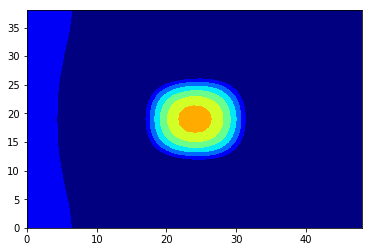

In [95]:
# t=0
# LIM = np.linspace(60, 400, 10, endpoint=True)
for i in tqdm(range(10000)):
    T=Update_T(u_,v_,T)
    plt.contourf(T[1:50,1:40].T,levels = 25,cmap='jet',vmin=280, vmax=400)
#     plt.colorbar()
    plt.savefig('T/%04d.png' % i)
    plt.cla()
#     if i %10==0:
#         t+=1       
#         plt.contourf(T[1:50,1:40].T,levels = 3,cmap='jet',vmin=60, vmax=400)
# #         plt.colorbar(ticks=v)
#         plt.savefig('T/%d.png'%t)

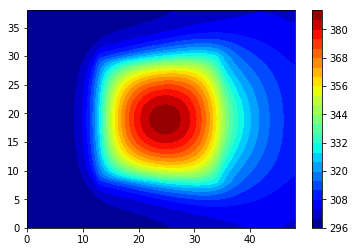

In [43]:
plt.contourf(T[1:50,1:40].T,levels = 25,cmap='jet')
plt.colorbar()

In [19]:

# v = np.linspace(298, 500, 10, endpoint=True)
# plt.contourf(T.T, v, cmap=plt.cm.jet)
# plt.colorbar(ticks=v)
# plt.show()

In [97]:
(97+80)/2

88.5